# 1. Initialize python imports, notebook window width,  and graphics window position
Should be executed automatically on start or restart, but isn't reliably. 

Keyboard shortcuts can be edited to use the sequence "ESC 0 9 ESC 0 i" to restart, clear all output and run all initialization cells successively.
Using ESC 0 0 instead of ESC 0 9 retains the output.

In [1]:
## %gui osx
import random as rand
import numpy as np
import genelife as g

%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt

# import pygame as pg # already done in genelife
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))     # sets input cells to use full window width

from os import environ
environ['SDL_VIDEO_WINDOW_POS'] = "%d,%d" % (1000,32)   # set position of pygame (SDL) video window (x,y) pixel coords, values work well on iMac

Running with SDL version 2.0.9.


# 2. Rebuilding with new array size
Execute the following cell with the new size edited in. Note that array sizes must be a power of 2.
Then remember to restart the kernel to load the newly compiled library.     You are then ready to execute examples in the new size.

In [ ]:
#  e.g. new size is 2^log2N where log2N is entered here      -.-
!sed -i -e 's/log2N = [0-9]*[0-9]/log2N = 9/' ../genelifec/genelife_size.h
import platform
if platform.system() == 'Darwin':
    !xcodebuild -project ../genelife.xcodeproj -scheme genelife build
elif platform.system() == 'Linux':
    ! bash ./make-files.sh
else:
    print("Not compatible with Windows or other operating systems")
    print("So you will need to recompile the C library externally")

# 3. Graphics notes

This notebook uses the SDL2 interface.

It pops up two SDL2 windows (labeled "Gene Life"), which must be moved to the side to see the notebook.

To stop the simulation mid-stream, you can OPTION click on either SDL2 window, click in the window. 

Simulations can be restarted using run() and the current timestep can be investigated graphically by calling run with updatesenabled = False. Initial state display with show0() and single stepping with step() are possible. 

The caption contains information about current state and mode.

Clicking on the window will give mouse position dependent information about local state.

Color is currently a 32 bit hash of the 64 bit gene value in colorfunction mode 0. There are 12 display modes accessible via left,right,up,down arrow keys:
The two windows can be assigned different colorfunction modes: but they start out locked (colorfunction2=-1)until an up/down key is pressed.
    0 Randomly hashed colors based on gene value
    1 Functional coloring - differs according to selection model : Overlay of non GoL rule cases in yellow
    2 Colouring by s value : in increasing shades of green/blue for central 0/1 gol state
    3 Colouring by processing state golgstats: (leading bits 7,6,5 determine brightness 7: bright 6: medium 5: dark)
         green: bright: mutation                  medium:  birth          dark: parent
         blue:  bright: survival or disambig used medium: parent dies     dark: normal death
         red:   bright: parentaldeath             medium: non golchange   dark: not gol rule
    4 Activity plot scaled as activity/(activity+ymax) with interactive */ 2 for ymax
    5 Population plot scaled as popln/(popln+ymax/10) with interactive */ 2 for ymax
    6 Genealogies of N most populated genes : 1 pixel/ancestral change (ancestor at top)
    7 Genealogies of N most pop'd genes: with vertical time from start, colors as in mode 0 rescaled by activity
    8 Glider detect: diff in packed 3-nbhoods with (dx,dy,dt), for (0,0,0) all 1-nbs with dt=-1 
    9 Connected component labelling with optimal matching to previous time step, "n" toggles novelty filter
    10 Activity plot for quadtree patterns of connected components (scaled as in 4) 
    11 Gene ancestors at chosen genealogical depth genealogycoldepth (under +/- control starting at 0), colored as in 0
    12 Glider detection using genetic displacement record

To change resolution N: (only powers of 2 are allowed, typically 8,9,10 for N=256,512,1024)
* change `subgenelife.c` line 17 (`log2N`) and rebuild c lib [we utilize the efficiency gains of N fixed as power of two at compile time]

Quadrant modes (keys Q,q,alt-q) are available for evolving parameters (selection < 8).

Horizon mode (toggle with key r) couples with strictly GoL rules in upper (sky) half-plane (selection < 8). Idea is that teeming life in the sea (lower halfplane) may evolve to colonize the sky (upper halfplane).

# 4. Initialization

See additional discussion in the [genelife wiki](https://github.com/js1200/genelife/wiki/Probability-parameters-in-genelife).

Parameter `rulemod` determines if genes are affecting the GOL dynamics at all.
* `rulemod == 0` => Genes have no affect; GOL dynamics prevail.  
* `rulemod == 1` => Genes alter GOL dynamics.

Parameter `repscheme` controls possible replication schemes for birth in the case of 3 live neighbours.  For 3 live neighbours, a unique one may be chosen deterministically in 2 ways:  (i) most different, and (ii) a particular nbr (0th) of a canonical rotation.  

Consider two cases, `repscheme bit 0 unset` and `repscheme bit 0 set`, and for each of these consider when `repscheme bit 1` is unset and set:

* `repscheme bit 0 unset`
    * `repscheme == 0` => use most different of the 3 live nbrs as ancestor
    * `repscheme == 2` => use 0th nbr of canonical rotation as ancestor
* `repscheme bit 0 set`
    * `repscheme == 1` => apply selection to complement pair of most different of the 3 live nbrs.
    * `repscheme == 3` => apply selection to complement pair of 0th nbr of canonical rotation

The `selection` parameter provides a choice between a variety of deterministic schemes to choose between two possible ancestors, either in the case of birth from 2 live neighbours or the two cases of birth from 3 live neighbours with `repscheme bit 0` set.
* `selection == 0` larger integer value determines survival
* `selection == 1` larger number of 1's 
* `selection == 2` paper-scissors-rock-well
* `selection == 3` selection based on closeness to one of the two difft targets (ncoding bits apart)
* `selection == 4` selection based on closeness of g0 to 0x0 and g1 to all 1's; for birth distances must satisfy `d0<ncoding`, `d1<ncoding`, and `dd=D(g0,g1) < ncoding.`  `ncoding>55` for any exceptions.
* `selection == 5` Predator prey: prey goes toward all 0's, predator goes toward all 1's.  N1(g)<32 => prey; birth if different and at least one prey; both prey => prey with less 1's wins, prey-predator => predator wins.

Parameter `nlog2pmut` fixes mutation probability.  `nlog2pmut` takes integer values, label them $k$; then  $p_{\rm mut} = 2^{-k}$

The simulation is set up to display for `ndisp` time steps, run without display for `nskip` time steps, and repeat, up to a total of `niter*ndisp` frames displayed (`niter*(ndisp+nskip)` total time steps):

|---`ndisp`---|------------------`nskip`---------------| ... repeated for `niter` times


In [ ]:
# we avoid text in the graphics window because of resolution issues
# if one needs text in Graphics Window proceed as follows: note that with 2x scaling the quality is poor because of pixelation    
# font rending for text at position : note result not ideal because of 2x scaling
#
# from pygame.locals import * 
# pg.font.init()
# default_font = pg.font.get_default_font()
# font_renderer = pg.font.Font(default_font, 7)
#
# example of text for a button   
# white = (200,200,200)
# labeltext = [font_renderer.render("%d" % (j*2,), 0, white) for j in range(5)]
# labeltext.append(font_renderer.render("S", 0, white))
# labeltext.append(font_renderer.render("O", 0, white))
# ncanon10s=['2s','3s','4s','5s','6s','2b','3b','4b','5b','6b']
# labeltext10 = [font_renderer.render(ncanon9s[j], 0, white) for j in range(len(ncanon9))]
# scr.blit(labeltext[j], (k*8,Height))           # transfer text to surface

# 5. Running

## 5.1 Example:  selection=4 cooperative birth

In [ ]:
# 4
#  selection=4 cooperative birth between near-0 and near-1 sequences with appropriate parameters for survival
#  Note that since two different sequences that cannot mutate directly into oneanother are required, birth is difficult
#  The system needs some non selective birth to proliferate : enforce birth with repscheme bits 3,4
#  The value of ncoding must be large, 24 or so, or non-specific replication takes over.
#  Color scheme: green near 0, read near 1, white neither. Near means within ncoding bits. 
g.nrun=1; g.ndisp=200; g.nskip=0; g.niter=100; # simulation time stepping parameters : set nskip=800 for faster long time
#nrun=1; ndisp=1; nskip=0; niter=1;          # single step
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
g.repscheme = g.runparams[1] = 0x03          # 0-1f: bit 0 on allow selection in 3 live nb configs, bit 1 on most difft vs 0 bit of canonical rotation
g.selection = g.runparams[2] = 4             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 3         # mask of 2 bits to overwrite instead of survival for 3(bit0) or 2(bit1) live nbs
g.survivalmask = g.runparams[4] = 2          # survive mask for two (bit 1) and three (bit 0) live neighbours : GoL = 3
g.colorfunction = g.runparams[5] = 7         # color function 0-8
g.initfield = g.runparams[6] = 200           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 7             # log2 gene mutation probability if <32, otherwise prob is val/2^-32 (0->0 prob)
g.initial1density = g.simparams[1] = 16384   # initial 1 density in GOL state
g.initialrdensity = g.simparams[2] = 0       # initial density of random genes
g.ncoding = g.simparams[3] = 12              # no of bits away from targets and each other allowed for match
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.repscheme=g.packrepscheme(g.repscheme,g.survivalmask,g.overwritemask) # packs bits together for compact display and image names
g.genelife.initialize_planes(g.npoffsets)      # genelife is the C interface module genelife_update_module
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0(False)
# step(False)
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, True)

## 5.2 Example:  selection=2 scissors-stone-well-paper

In [7]:
# 2
#  selection=2 scissors-stone-well-paper
#  Note that sequences must differ for replication unless it is forced.
#  
#  Color scheme: four different classes are red, green, blue and white
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=100;  # simulation time stepping parameters
#nrun=1; ndisp=1; nskip=0; niter=1;         # single step
g.nhist = 10                                # set to n to turn on histogram configurations every nth step
g.nstat = 10                                # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1              # 0,1 whether to allow GoL rule modifications
                                            # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
g.repscheme = g.runparams[1] = 0x0002       # bits 0 to 20 code for mostly independent binary options
g.selection = g.runparams[2] = 2            # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 3        # mask of 2 bits to overwrite instead of survival for 3(bit0) or 2(bit1) live nbs
g.survivalmask = g.runparams[4] = 0         # survive mask for two (bit 1) and three (bit 0) live neighbours : GoL = 3
g.colorfunction = g.runparams[5] = 0        # color function 0(hash), ≥1(fnal), 2 nongolchg yellow, 3 notgolrul yellow
g.initfield = g.runparams[6] = 100          # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8            # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] = 8192   # initial 1 density in GOL state
                                            # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 0          # initial density of random genes
g.ncoding = g.simparams[3] = 0                  # no of bits used to encode valid connection functions 1-16
g.startgenechoice = g.simparams[4] = 8          # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.rescale = True                            # if true, windows rescaled to 2x if possible (<= 512 in size), must restart kernel to change
g.show0(False)
#g.step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

step 135 colorfunction changed to 1
step 154 colorfunction changed to 2
step 180 colorfunction changed to 3
step 195 colorfunction changed to 4
step 203 colorfunction changed to 5
step 220 colorfunction changed to 6
step 252 colorfunction changed to 7
step 274 colorfunction changed to 8


### 5.2.2 Ongoing pattern evolution with no mutation : deterministic evolution

In [6]:
# 2
#  selection=2 scissors-stone-well-paper
#  Note that sequences must differ for replication unless it is forced.
#  
#  Color scheme: four different classes are red, green, blue and white
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=100;  # simulation time stepping parameters
#nrun=1; ndisp=1; nskip=0; niter=1;         # single step
g.nhist = 10                                # set to n to turn on histogram configurations every nth step
g.nstat = 10                                # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1              # 0,1 whether to allow GoL rule modifications
                                            # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
g.repscheme = g.runparams[1] = 0x0002       # bits 0 to 20 code for mostly independent binary options
g.selection = g.runparams[2] = 2            # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 3        # mask of 2 bits to overwrite instead of survival for 3(bit0) or 2(bit1) live nbs
g.survivalmask = g.runparams[4] = 0         # survive mask for two (bit 1) and three (bit 0) live neighbours : GoL = 3
g.colorfunction = g.runparams[5] = 0        # color function 0(hash), ≥1(fnal), 2 nongolchg yellow, 3 notgolrul yellow
g.initfield = g.runparams[6] = 100          # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 0            # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] = 8192   # initial 1 density in GOL state
                                            # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 0          # initial density of random genes
g.ncoding = g.simparams[3] = 0                  # no of bits used to encode valid connection functions 1-16
g.startgenechoice = g.simparams[4] = 8          # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.rescale = True                            # if true, windows rescaled to 2x if possible (<= 512 in size), must restart kernel to change
g.show0(False)
#g.step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

image saved ./images/genelife_sel02_t508_r00000002_s008_c10.jpeg
image saved ./images/genelife_sel02_t508_r00000002_s009_c00.jpeg
step 508 colorfunction changed to 12
image saved ./images/genelife_sel02_t508_r00000002_s010_c12.jpeg
step 508 colorfunction changed to 11
step 508 colorfunction changed to 10
step 508 colorfunction changed to 11
step 508 colorfunction changed to 10
step 508 colorfunction changed to 9
image saved ./images/genelife_sel02_t508_r00000002_s011_c09.jpeg
image saved ./images/genelife_sel02_t1002_r00000002_s012_c09.jpeg
image saved ./images/genelife_sel02_t1002_r00000002_s013_c10.jpeg
step 1002 colorfunction2 changed to 11
step 1002 colorfunction2 changed to 12
image saved ./images/genelife_sel02_t1002_r00000002_s014_c12.jpeg
step 1002 colorfunction2 changed to 11
image saved ./images/genelife_sel02_t1002_r00000002_s015_c11.jpeg
step 1002 colorfunction2 changed to 12
step 1002 colorfunction2 changed to -1
step 1002 colorfunction2 changed to 12
step 1002 colorfuncti

In [10]:
# 2
#  selection=2 scissors-stone-well-paper
#  Note that sequences must differ for replication unless it is forced.
#  
#  Color scheme: four different classes are red, green, blue and white
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=100;  # simulation time stepping parameters
#nrun=1; ndisp=1; nskip=0; niter=1;         # single step
g.nhist = 10                                # set to n to turn on histogram configurations every nth step
g.nstat = 10                                # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1              # 0,1 whether to allow GoL rule modifications
                                            # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
g.repscheme = g.runparams[1] = 0x0002       # bits 0 to 20 code for mostly independent binary options
g.selection = g.runparams[2] = 2            # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 3        # mask of 2 bits to overwrite instead of survival for 3(bit0) or 2(bit1) live nbs
g.survivalmask = g.runparams[4] = 0         # survive mask for two (bit 1) and three (bit 0) live neighbours : GoL = 3
g.colorfunction = g.runparams[5] = 0        # color function 0(hash), ≥1(fnal), 2 nongolchg yellow, 3 notgolrul yellow
g.initfield = g.runparams[6] = 100          # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 0            # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] = 8192   # initial 1 density in GOL state
                                            # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 0          # initial density of random genes
g.ncoding = g.simparams[3] = 0                  # no of bits used to encode valid connection functions 1-16
g.startgenechoice = g.simparams[4] = 8          # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.rescale = True                            # if true, windows rescaled to 2x if possible (<= 512 in size), must restart kernel to change
g.show0(False)
#g.step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

step 10010 collected trace of nnovelcells


Text(0, 0.5, 'novel cells')

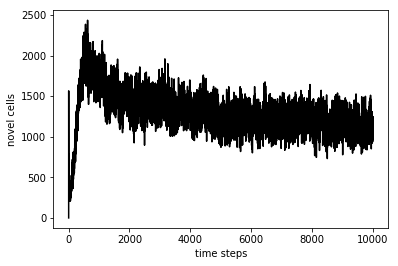

In [16]:
plt.plot(g.nnovelcells[:g.framenr],'black')
plt.xlabel('time steps')
plt.ylabel('novel cells')

In [ ]:
gliderinfo = np.zeros(408,dtype=np.uint64)
g.genelife.get_gliderinfo(gliderinfo)

In [ ]:
#plt.yscale('log', nonposy='clip')
f, axarr = plt.subplots(4, 2)
for i in range(2):
    for j in range(4):
        axarr[j,i].plot.yscale('log', nonposy='clip')
        axarr[j,i].hist(gliderinfo[range(0,51)]);


## 5.3 Analysis of gene and connected component pattern data for entire history

In [ ]:
maxngenes = 2000000
# genedtype=[('popcount',c_uint32),('firsttime',c_uint32),('lasttime',c_uint32),('lastextinctiontime',c_int32),    #    3 unsigned 1 signed int 32 bits
#            ('activity',c_uint32),('nextinctions',c_uint32),('gene',c_uint64),('firstancestor',c_uint64)]         #    2 unsigned 32 bit and 2 unsigned 64 bit int
genelist = np.zeros(maxngenes,dtype=g.genelife.genedtype)
ngenes=g.genelife.get_genes(genelist)
# print(g.genelife.genedtype)
print('ngenes',ngenes)
print('      gene        firstancestor   popcount  firsttime lasttime lastextinctiontime nextinctions activity')
for i in range(ngenes):
    foo = "%16x %16x %8d %8d %8d %14d %12d %14d" % \
    (genelist[i]['gene'], genelist[i]['firstancestor'], genelist[i]['popcount'],genelist[i]['firsttime'], genelist[i]['lasttime'],
     genelist[i]['lastextinctiontime'], genelist[i]['nextinctions'], genelist[i]['activity'] )
    print(foo)

In [ ]:
maxncomponents = 1000000
#compdtype=[('N',c_uint16),('S',c_uint16),('W',c_uint16),('E',c_uint16),('lastrc',c_uint16),
#                ('label',c_uint16),('log2n',c_uint16),('patt',c_uint16),('quad',c_uint64),('pixels',c_uint32),('reserve',c_uint32)]
complist = np.zeros(maxncomponents,dtype=g.genelife.compdtype)
ncomponents=g.genelife.get_components(complist)
print(g.genelife.compdtype)
print('ncomponents',ncomponents)
print('label    N    S    W    E  pixels log2n    patt       quad')
for i in range(ncomponents):
    foo= " %4d %4d %4d %4d %4d %7d %6d %8x %16x" % \
    (complist[i]['label'], complist[i]['N'], complist[i]['S'], complist[i]['W'], complist[i]['E'], complist[i]['pixels'],
     complist[i]['log2n'], complist[i]['patt'], complist[i]['quad'])
    print(foo)

In [ ]:
maxsmallpatts = 65536
# smallpattdtype defined in genelife_update_module.py
# smallpattdtype=[('topactivity',c_uint32),('activity',c_uint32),('firsttime',c_uint32),('lasttime',c_uint32)]
# print(g.genelife.smallpattdtype)
smallpatts = np.zeros(maxsmallpatts,dtype=g.genelife.smallpattdtype)
nsmallpatts=g.genelife.get_smallpatts(smallpatts)
print('nsmallpatts',nsmallpatts)
# output table of first 100 values
print('   patt    size  activity  firsttime  lasttime')
for i in range(100):
    print(" %8d %8d %10d %10d %10d" % (i, smallpatts[i]['topactivity'], smallpatts[i]['activity'], smallpatts[i]['firsttime'],smallpatts[i]['lasttime']))
histnodes = np.zeros(10)
for i in range(len(smallpatts)):
    if (smallpatts[i]['activity'] and i):
        if i==1: 
            log2n = 0
        else: 
            log2n = int(1+np.log2(int(np.sqrt(i-1))))
        histnodes[log2n]=histnodes[log2n]+1
for i in range(10):
    print(i,'%7d' % histnodes[i],'out of possible 2^',2**(2*i),'-1')

In [ ]:
maxquadnodes = 500000
# quaddtype defined in genelife_update_module.py
quadnodes = np.zeros(maxquadnodes,dtype=g.genelife.quaddtype)
histnodes = np.zeros(10)
nallspeciesquad=g.genelife.get_quadnodes(quadnodes)
# print(g.genelife.quaddtype)
print('nallspeciesquad',nallspeciesquad)
print('     nr          hashkey               nw               ne               sw               se  isnode  size   activity  pop1s  firsttime  lasttime')
for i in range(100):
    foo = " %6d %16x %16x %16x %16x %16x %5d %6d %6d %8d %10d %10d" % \
    (i, quadnodes[i]['hashkey'], quadnodes[i]['nw'], quadnodes[i]['ne'], quadnodes[i]['sw'], quadnodes[i]['se'], quadnodes[i]['isnode'],
     quadnodes[i]['size'], quadnodes[i]['activity'], quadnodes[i]['pop1s'], quadnodes[i]['firsttime'],quadnodes[i]['lasttime'])
    print(foo)
                          
for i in range(len(quadnodes)):
    if (quadnodes[i]['size']):
        log2n = int(np.log2(quadnodes[i]['size']))
        histnodes[log2n]=histnodes[log2n]+1
for i in range(len(smallpatts)):
    if (smallpatts[i]['activity'] and i):
        if i==1: log2n = 0
        else: log2n = int(1+np.log2(int(np.sqrt(i-1)))) 
for i in range(10):
    print(i,'%7d' % histnodes[i],'out of possible 2^',2**(2*i),'-1')


In [ ]:
# getting genes, popcounts and activities up to python
maxngenes = 100000
genes=np.zeros(maxngenes,np.uint64)
activities=np.zeros(maxngenes,np.int32)
activitiesl=np.zeros(maxngenes,np.int32)
maxnquads = 200000
quads=np.zeros(maxnquads,np.uint64)
activitiesq=np.zeros(maxnquads,np.int32)

nlivespecies=g.genelife.get_activities(genes,activitiesl)
print('nlivespecies',nlivespecies)
if nlivespecies >= 3:
    print('first three  ', 0,genes[0],activitiesl[0],'  ',1,genes[1],activitiesl[1], '  ',2,genes[2],activitiesl[2])

nspecies=g.genelife.get_all_activities(genes,activities)
print('nspecies',nspecies)
if nspecies >= 3:
    print('first three  ', 0,genes[0],activities[0],'  ',1,genes[1],activities[1], '  ',2,genes[2],activities[2])

nquadspecies=g.genelife.get_quad_activities(quads,activitiesq)
print('nquadspecies',nquadspecies)
if nspecies >= 3:
    print('first three  ', 0,quads[0],activitiesq[0],'  ',1,quads[1],activitiesq[1], '  ',2,quads[2],activitiesq[2])


In [ ]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt

In [ ]:
plt.yscale('log', nonposy='clip')
#plt.hist(activities,bins=100);
#plt.hist(activities,bins=100,range=(2000,4000));
plt.hist(activities,bins=100,range=(0,2000));

In [ ]:
np.__version__

In [ ]:
ac = [activities[i] for i in range(len(activities)) if activities[i]>1]
qq = [x/10 for x in range(10)]
foo = np.quantile(ac,qq)
foo

In [ ]:
activity(500)

In [ ]:
from matplotlib import animation, rc
from IPython.display import HTML

In [ ]:
def animate(i):
    g.genelife.genelife_update(1,0,0)
    nspecies=g.genelife.get_all_activities(genes,activities)
    foo = plt.hist(activities,bins=100,range=(2000,4000))
    return (foo,)

In [ ]:
np.linspace(0, 2*np.pi, 128)

In [ ]:
plt.close()
for _ in range(20):
    g.genelife.genelife_update(1,0,0)
    nspecies=g.genelife.get_all_activities(genes,activities)
    plt.cla()
    plt.hist(activities,bins=100,range=(2000,4000));
    plt.show()
    

In [ ]:
# not certain how well this is working : see identical gene indices below , use previous cell in the meantime
gindices=np.zeros(10000,np.int32)
genes=np.zeros(10000,np.uint64)
popln=np.zeros(10000,np.int32)
activities=np.zeros(10000,np.int32)

nspecies=g.genelife.get_sorted_popln_act(gindices,genes,popln,activities)  #nspecies is only those with popcount nonzero
print("no of species",nspecies,len(popln))
print(popln[0:nspecies])
print(genes[0:nspecies])
for i in range(len(activities)):
    if activities[i]: imax = i;
print(imax)


## 5.4 Trace of number of live cell statistics

In [ ]:
ntmax = 1024
while g.framenr//g.nstat > ntmax: ntmax = ntmax*2   # increase ntmax to next power of 2 to match C memory
tpts=np.zeros(ntmax,np.int32)
livestats = np.zeros(ntmax,np.int32)
genotypes = np.zeros(ntmax*4,np.int32)
genotypes4 = np.reshape(genotypes,(ntmax,4)).T
stepstats = np.zeros(ntmax*10,np.int32)
stepstats10 = np.reshape(stepstats,(ntmax,10)).T
configstats = np.zeros(ntmax*4,np.int32)
configstats4 = np.reshape(configstats,(ntmax,4)).T

In [ ]:
nt = g.framenr//g.nstat
g.genelife.get_stats(livestats,genotypes,stepstats,configstats,nt)
tpts = [i*g.nstat for i in range(1,nt)]

In [ ]:
%matplotlib inline
# fig, ax = plt.subplots()
g.plt.rcParams['figure.figsize'] = [10, 10]
f, (ax1, ax2, ax3) = g.plt.subplots(3, sharex=True, sharey=False)
ax1.plot(tpts,stepstats10[0][1:nt],'b',label='notgolrul')
ax1.plot(tpts,stepstats10[1][1:nt],'g',label='2_live')
ax1.plot(tpts,stepstats10[2][1:nt],'r',label='3_live')
ax1.plot(tpts,stepstats10[3][1:nt],'c',label='birth')
ax1.plot(tpts,stepstats10[4][1:nt],'m',label='mutation')
ax1.plot(tpts,stepstats10[5][1:nt],'b--',label='2select')
ax1.plot(tpts,stepstats10[6][1:nt],'g--',label='survival')
ax1.plot(tpts,stepstats10[7][1:nt],'r--',label='death')
ax1.plot(tpts,stepstats10[8][1:nt],'k--',label='golstate')
ax1.plot(tpts,stepstats10[9][1:nt],'m--',label='3g_same')
ax2.plot(tpts,genotypes4[0][1:nt],'b',label='d=0 class')
ax2.plot(tpts,genotypes4[1][1:nt],'g',label='d=1 class')
ax2.plot(tpts,genotypes4[2][1:nt],'r',label='d=2 class')
ax2.plot(tpts,genotypes4[3][1:nt],'k',label='d=3 class')
ax3.plot(tpts,configstats4[0][1:nt],'b',label='offset [-1, 0,-1]')
ax3.plot(tpts,configstats4[1][1:nt],'g',label='offset [ 1, 0,-1]')
ax3.plot(tpts,configstats4[2][1:nt],'r',label='offset [ 0,-1,-1]')
ax3.plot(tpts,configstats4[3][1:nt],'k',label='offset [ 0, 1,-1]')
ax1.set_ylabel('number of such cells')
ax2.set_ylabel('number of such cells')
ax3.set_ylabel('number of such configs')
legend1 = ax1.legend(loc=2, bbox_to_anchor=(1,1), shadow=True, fontsize='small')  # or use  loc = 'best'
legend2 = ax2.legend(loc=2, bbox_to_anchor=(1,1), shadow=True, fontsize='small')
legend3 = ax3.legend(loc=2, bbox_to_anchor=(1,1), shadow=True, fontsize='small')
legend1.get_frame().set_facecolor('C0')
legend2.get_frame().set_facecolor('C0')
legend3.get_frame().set_facecolor('C0')
g.plt.show()

## 5.5 Space-time of one row

In [ ]:
g.genelife.get_curgol(g.gol)
rng = list(range(g.N))
cnt = list(range(g.N))
for i in rng:
    cnt[i] = sum([g.gol[(i*g.N)+j] for j in rng])

In [ ]:
foo = [(i,cnt[i]) for i in range(g.N) if cnt[i] == max(cnt)]

myrow = foo[0][0]
for i in range(g.N):
    g.genelife.get_curgol(g.gol)
    for j in range(g.N):
        if g.gol[(g.N*myrow)+j]==1:
            g.cgrid[i][j] = 1
        else:
            g.cgrid[i][j] = 0
    g.genelife.genelife_update(1,0,0)
    

In [ ]:
%matplotlib inline

In [ ]:
my_dpi=96
my_cmap = g.rand_cmap(257, type='bright', first_color_black=True, last_color_black=False)

fig, ax = g.plt.subplots(figsize=((3*256)/my_dpi, (3*256)/my_dpi), dpi=my_dpi, frameon=False)
ax.axis('off')
# mat = ax.matshow(cgrid, cmap=my_cmap, vmin=0.01, vmax=257)  # was vmax = LEN+1
mat = ax.matshow(g.cgrid, cmap=my_cmap, vmin = 0, vmax = 56)
g.plt.show()

# 6. Gallery of example simulations
use ctrl-return to execute cell and stay on same cell

## 0 Selection:  Numerical value of gene determines fitness

In [ ]:
# 0
#  selection=0 gene value
#  Note that sequences must differ for replication unless it is forced.
#   
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=100;  # simulation time stepping parameters
#nrun=1; ndisp=1; nskip=0; niter=1;              # single step
g.nhist = 10                                     # set to n to turn on histogram configurations every nth step
g.nstat = 10                                     # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1                   # 0,1 whether to allow GoL rule modifications
                                                 # if 0, gene dynamics consistent with GoL still possible
g.repscheme = g.runparams[1] = 0x3               # bits 0 to 13 code for binary options, 14-20 code for quadrant pairs,
                                                 # 21-24 for allowed canonical 2-live nb configs 
                                                 # value 0x11 is simply game of life provided survivalmask is 3
g.selection = g.runparams[2] = 0                 # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.survivalmask = g.runparams[4] = 2              # survive mask for two (bit 1) and three (bit 0) live neighbours : GoL = 3
g.birthmask = 1                                  # birth mask for two (bit 1) and three (bit 0) live neighbours : GoL = 1
g.overwritemask = g.runparams[3] = 3             # mask of 2 bits to overwrite instead of survival for 3(bit0) or 2(bit1) live nbs

g.colorfunction = g.runparams[5] = 0             # color function 0(hash), ≥1(fnal), 2 nongolchg yellow, 3 notgolrul yellow
g.initfield = g.runparams[6] = 200               # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8                 # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] = 16384       # initial 1 density in GOL state
                                                 # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 0           # initial density of random genes
g.ncoding = g.simparams[3] = 0                   # bits0-7 no of bits used to encode individual gene functions
                                                 # bits8-15 no of bits to encode masks for add2ndmask1st functions
                                                 # bits 16-23 number of planes used in selection modesl 10-12 
g.startgenechoice = g.simparams[4] = 8           # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
#step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, True)

## 1 Selection: Number of 1s in gene determines fitness

In [ ]:
# 1
#  selection=1 number of ones determines fitness
#  Note that sequences must differ in number of ones for replication unless it is forced.
#  ncoding plays no role, system takes about 4-5000 steps to reach all ones sequence
#  Color scheme: color gradient with colors going from black (no 1s) to white (all 1s)
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=100;  # simulation time stepping parameters
g.nhist = 0                                      # set to n to turn on histogram configurations every nth step
g.nstat = 0                                      # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1                   # 0,1 whether to allow GoL rule modifications
g.repscheme = g.runparams[1] = 0x3               # bit 0,1 on allow selection in 3,2 live nb configs
g.selection = g.runparams[2] = 1                 # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0x3           # mask of 2 bits to overwrite instead of survival for 3(bit0) or 2(bit1) live nbs
g.survivalmask = g.runparams[4] = 2              # survive mask for two (bit 1) and three (bit 0) live neighbours : GoL = 3
g.colorfunction = g.runparams[5] = 1             # color function 0-8
g.initfield = g.runparams[6] = 200               # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8                 # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] = 16384       # initial 1 density in GOL state
g.initialrdensity = g.simparams[2] = 0           # initial density of random genes
g.ncoding = g.simparams[3] = 0                   # no of bits used to encode valid connection functions 1-16
g.startgenechoice = g.simparams[4] = 8           # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
#step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

## 2 Selection: Not well-ordered (tournament) selection - scissors-stone-well-paper model

In [ ]:
# 2
#  selection=2 scissors-stone-well-paper
#  Note that sequences must differ for replication unless it is forced.
#  
#  Color scheme: four different classes are red, green, blue and white
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=100;  # simulation time stepping parameters
g.nhist = 10                                # set to n to turn on histogram configurations every nth step
g.nstat = 10                                # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1              # 0,1 whether to allow GoL rule modifications
                                            # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
g.repscheme = g.runparams[1] = 0x3          # bits 0 to 20 code for mostly independent binary options
g.selection = g.runparams[2] = 2            # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 3        # mask of 2 bits to overwrite instead of survival for 3(bit0) or 2(bit1) live nbs
g.survivalmask = g.runparams[4] = 0         # survive mask for two (bit 1) and three (bit 0) live neighbours : GoL = 3
g.colorfunction = g.runparams[5] = 1        # color function 0(hash), ≥1(fnal), 2 nongolchg yellow, 3 notgolrul yellow
g.initfield = g.runparams[6] = 200          # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8            # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] = 8192   # initial 1 density in GOL state
                                            # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 0      # initial density of random genes
g.ncoding = g.simparams[3] = 0              # no of bits used to encode valid connection functions 1-16
g.startgenechoice = g.simparams[4] = 8      # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0(False)
#step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

## 3 Selection: Cyclic not well-ordered selection for 4 species

In [ ]:
# 3
#  selection=3 scissors-stone-well-paper but only next color wins
#  Note that sequences must differ for replication unless it is forced.
#  
#  Color scheme: four different classes are red, green, blue and white
nrun=1; ndisp=1000; nskip=0; niter=100;  # simulation time stepping parameters
nhist = 0                                # set to n to turn on histogram configurations every nth step
nstat = 0                                # set to n to turn on statistics trace every nth step
rulemod = runparams[0] = 3               # 0,1 whether to allow GoL rule modifications
repscheme = runparams[1] = 0x2ab         # 0-1f: bit 0 on allow selection in 3 live nb configs, bit 1 on most difft vs 0 bit of canonical rotation
selection = runparams[2] = 3             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
overwritemask = runparams[3] = 0         # mask of 2 bits to overwrite instead of survival for 3(bit0) or 2(bit1) live nbs
survivalmask = runparams[4] = 0          # survive mask for two (bit 1) and three (bit 0) live neighbours : GoL = 3
colorfunction = runparams[5] = 1         # color function 0-8
initfield = runparams[6] = 200            # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
nlog2pmut = simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
initial1density = simparams[1] = 16384   # initial 1 density in GOL state
initialrdensity = simparams[2] = 0       # initial density of random genes
ncoding = simparams[3] = 0               # not used in selection==2
startgenechoice = simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

genelife.initialize_planes(npoffsets)
genelife.initialize(runparams,simparams)
framenr = 0
cnt=0
show0()
#step()
run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

## 4 Selection: Cooperative birth requiring two individuals with different gene functions

In [ ]:
# 4
#  selection=4 cooperative birth between near-0 and near-1 sequences with appropriate parameters for survival
#  Note that since two different sequences that cannot mutate directly into oneanother are required, birth is difficult
#  The system needs some non selective birth to proliferate : overwritemask 3
#  For random start the ncoding value must be large, 28 or so.
#  Color scheme: green near 0, read near 1, white neither. Near means within ncoding bits. 
nrun=1; ndisp=200; nskip=0; niter=100;   # simulation time stepping parameters : set nskip=800 for faster long time
nhist = 0                                # set to n to turn on histogram configurations every nth step
nstat = 0                                # set to n to turn on statistics trace every nth step
rulemod = runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
repscheme = runparams[1] = 0x03          # 0-1f: bit 0 on allow selection in 3 live nb configs, bit 1 on most difft vs 0 bit of canonical rotation
selection = runparams[2] = 4             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
overwritemask = runparams[3] = 3         # mask of 2 bits to overwrite instead of survival for 3(bit0) or 2(bit1) live nbs
survivalmask = runparams[4] = 2          # survive mask for two (bit 1) and three (bit 0) live neighbours : GoL = 3
colorfunction = runparams[5] = 1         # color function 0-8
initfield = runparams[6] = 200            # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
nlog2pmut = simparams[0] = 7             # log2 gene mutation probability (0 or >56 means no mutation)
initial1density = simparams[1] = 16384   # initial 1 density in GOL state
initialrdensity = simparams[2] = 0       # initial density of random genes
ncoding = simparams[3] = 12              # no of bits away from targets and each other allowed for match
startgenechoice = simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

genelife.initialize_planes(npoffsets)
genelife.initialize(runparams,simparams)
framenr = 0
cnt=0
show0()
#step()
run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

## 5 Selection: Predator-prey model

In [ ]:
# 5
#  selection=5 with appropriate parameters for survival
#  Note that since two different sequences that cannot mutate directly into oneanother are required, birth is difficult
#  The system needs some non selective birth to proliferate : enforce birth with repscheme bits 3,4
#  Predator and prey must be within ncoding bits of one another
g.nrun=1; g.ndisp=200; g.nskip=800; g.niter=100; # simulation time stepping parameters
g.nhist = 0                                      # set to n to turn on histogram configurations every nth step
g.nstat = 0                                      # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1                   # 0,1 whether to allow GoL rule modifications
g.repscheme = g.runparams[1] = 0x33              # 0-1f: bit 0 on allow selection in 3 live nb configs, bit 1 on most difft vs 0 bit of canonical rotation
g.selection = g.runparams[2] = 5                 # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 3             # mask of 2 bits to overwrite instead of survival for 3(bit0) or 2(bit1) live nbs
g.survivalmask = g.runparams[4] = 2              # survive mask for two (bit 1) and three (bit 0) live neighbours : GoL = 3
g.colorfunction = g.runparams[5] = 1             # color function 0-8
g.initfield = g.runparams[6] = 200               # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 7                 # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] = 16384       # initial 1 density in GOL state
g.initialrdensity = g.simparams[2] = 0           # initial density of random genes
g.ncoding = g.simparams[3] = 8                   # no of bits used to encode valid connection functions 1-16
g.startgenechoice = g.simparams[4] = 8           # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
#step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

## 6 Selection: Constrained selection involving two targets and distance constraint

In [ ]:
# 6
#  selection=6 with appropriate parameters for survival
#  in this model there are two target gene centres at all 0 sequence and the sequence with ncoding leading 1s
#  birth occurs if the two sequences have different distances to each target and these are less than their mutual distance
# the sequence which is closer to its target in selected as the ancestor for birth
# the initial asymmetry was corrected by disallowing equal distances to the targets (a biassed choice was made)
# one can enforce birth using repscheme, in which case the canonical rotation is used to maintain symmetry
nrun=1; ndisp=200; nskip=0; niter=1;       # simulation time stepping parameters
nhist = 0                                # set to n to turn on histogram configurations every nth step
nstat = 0                                # set to n to turn on statistics trace every nth step
rulemod = runparams[0] = 0               # 0,1 whether to allow GoL rule modifications
repscheme = runparams[1] = 7             # for selection 10 or 11, repscheme gives number of planes in simulation (0->16)
selection = runparams[2] = 6             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
overwritemask = runparams[3]= 0x0        # mask of 2 bits to overwrite instead of survival for 3(bit0) or 2(bit1) live nbs
survivalmask = runparams[4] = 0x3        # selection 10,11: survival bit 0 determines if current plane used as well for nbs
colorfunction = runparams[5] = 0         # color function 0-8
initfield = runparams[6] = 150            # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
nlog2pmut = simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
initial1density = simparams[1] =  16384  # initial 1 density in GOL state
initialrdensity = simparams[2] = 0       # initial density of random genes
ncoding = simparams[3] = 0               # number of bits coding for functions
startgenechoice = simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

genelife.initialize_planes(npoffsets)
genelife.initialize(runparams,simparams)
framenr = 0
cnt=0
show0()
# step()
run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

## 7 Selection: Neutral but different

In [ ]:
# 7
#  selection=7 with appropriate parameters for survival
#  in this version selection is neutral, but fails if the sequences are the same
g.nrun=1; g.ndisp=200; g.nskip=0; g.niter=1;       # simulation time stepping parameters
g.nhist = 0                                # set to n to turn on histogram configurations every nth step
g.nstat = 0                                # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
g.repscheme = g.runparams[1] = 3             # for selection 10 or 11, repscheme gives number of planes in simulation (0->16)
g.selection = g.runparams[2] = 7             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3]= 0x0        # mask of 2 bits to overwrite instead of survival for 3(bit0) or 2(bit1) live nbs
g.survivalmask = g.runparams[4] = 0x3        # selection 10,11: survival bit 0 determines if current plane used as well for nbs
g.colorfunction = g.runparams[5] = 0         # color function 0-8
g.initfield = g.runparams[6] = 150            # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  16384  # initial 1 density in GOL state
g.initialrdensity = g.simparams[2] = 0       # initial density of random genes
g.ncoding = g.simparams[3] = 0               # number of bits coding for functions
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
# step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

## 8 Selection: Totalistic LUT encoded by gene (fixed length direct encoding)

### 8.1 Game of Life with selection==8

In [2]:
#  8 
#  selection=8 sum totalistic LUT with appropriate parameters for survival and genes encoding LUt in fixed length direct encoding
#  this case uses the genes to encode the totalistic (s dept) rule tables for birth and survival
#  birth is determined by the and of the live neighbour genes (bits 8-15 for ncoding=1) ie genecode
#  survival is determined the and of the live neighbour genes (bits 0-8 for ncoding=1) ie genecode
#  in an alternative version (see commented line in update_lut_sum) survival is by the central live neighbour gene
#  ncoding may be set (1-7) to require more bits of gene be 1 to turn on a rule
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=1; # simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
g.repscheme = g.runparams[1] = 0x160         # 0 defaults 6 penalizes too many rules 1 trivial disambiguation
g.selection = g.runparams[2] = 8             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0x00      # mask of bits to overwrite if birth allowed and already occupied for bit position sum s
g.survivalmask = g.runparams[4] = 0x06       # GoL constraint if genes stay active
g.birthmask = g.runparams[7] = 0x04          # GoL constraint if genes stay active 
g.ancselectmask = g.runparams[8] = 0xff      # Allow ancestor selection on all s values for which birth is allowed 
g.colorfunction = g.runparams[5] = 0         # color function: choose 0-12 using arrows
g.initfield = g.runparams[6] = 100           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  8192   # initial 1 density in GOL state: 16384 = nearest to half of  C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 0       # initial density of random genes
g.ncoding = g.simparams[3] = 0x1             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
#g.step()
#g.step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

/Users/john/projects/genelife_private/fastgenegol/genelifepy/genelife.py:450: ExperimentalWarning: 'pixels2d' is in an experimental state.
  cgrid=sdl2.ext.pixels2d(surfacex1)
/Users/john/projects/genelife_private/fastgenegol/genelifepy/genelife.py:489: ExperimentalWarning: 'pixels2d' is in an experimental state.
  cgrid2=sdl2.ext.pixels2d(surface2x1)


### 8.2 Scissors-paper-stone-well selection with selection==8

* standard subselection mode 7 (repscheme 170) 
* population of gliders with long term cooperation 

In [11]:
#  8 
#  selection=8 sum totalistic LUT with appropriate parameters for survival and genes encoding LUt in fixed length direct encoding
#  this case uses the genes to encode the totalistic (s dept) rule tables for birth and survival
#  birth is determined by the and of the live neighbour genes (bits 8-15 for ncoding=1) ie genecode
#  survival is determined the and of the live neighbour genes (bits 0-8 for ncoding=1) ie genecode
#  in an alternative version (see commented line in update_lut_sum) survival is by the central live neighbour gene
#  ncoding may be set (1-7) to require more bits of gene be 1 to turn on a rule
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=1; # simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                             # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
g.repscheme = g.runparams[1] = 0x170         # 
g.selection = g.runparams[2] = 8             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0x6       # mask of bits to overwrite if birth allowed and already occupied for bit position sum s
g.survivalmask = g.runparams[4] = 0x0        # GoL constraint if genes stay active
g.birthmask = g.runparams[7] = 0x6          # GoL constraint if genes stay active 
g.ancselectmask = g.runparams[8] = 0xff      # Allow ancestor selection on all s values for which birth is allowed 
g.colorfunction = g.runparams[5] = 9         # color function: use arrow keys to select 0-12
g.initfield = g.runparams[6] = 100           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  8192   # initial 1 density in GOL state
                                             # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 0       # initial density of random genes
g.ncoding = g.simparams[3] = 0x1             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
#g.step()
#g.step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

### 8.3 Or of neighbours for genetic coding of rule

In [ ]:
#  8 
#  selection=8 sum totalistic LUT with appropriate parameters for survival and genes encoding LUt in fixed length direct encoding
#  this case uses the genes to encode the totalistic (s dept) rule tables for birth and survival
#  birth is determined by the and of the live neighbour genes (bits 8-15 for ncoding=1) ie genecode
#  survival is determined the and of the live neighbour genes (bits 0-8 for ncoding=1) ie genecode
#  in an alternative version (see commented line in update_lut_sum) survival is by the central live neighbour gene
#  ncoding may be set (1-7) to require more bits of gene be 1 to turn on a rule
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=1; # simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                             # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
g.repscheme = g.runparams[1] = 0x1b2         # 
g.selection = g.runparams[2] = 2             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0x1e       # mask of bits to overwrite if birth allowed and already occupied for bit position sum s
g.survivalmask = g.runparams[4] = 0x0        # GoL constraint if genes stay active
g.birthmask = g.runparams[7] = 0x1e          # GoL constraint if genes stay active 
g.ancselectmask = g.runparams[8] = 0xff      # Allow ancestor selection on all s values for which birth is allowed 
g.colorfunction = g.runparams[5] = 9         # color function: use arrow keys to select 0-12
g.initfield = g.runparams[6] = 0             # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  16384   # initial 1 density in GOL state
                                             # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 16384       # initial density of random genes
g.ncoding = g.simparams[3] = 0x1             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
#g.step()
#g.step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

### 8.4 Test of symmetry breaking expansion of rules : here basal level

In [26]:
#  8 
#  selection=8 sum totalistic LUT with appropriate parameters for survival and genes encoding LUt in fixed length direct encoding
#  this case uses the genes to encode the totalistic (s dept) rule tables for birth and survival
#  birth is determined by the and of the live neighbour genes (bits 8-15 for ncoding=1) ie genecode
#  survival is determined the and of the live neighbour genes (bits 0-8 for ncoding=1) ie genecode
#  in an alternative version (see commented line in update_lut_sum) survival is by the central live neighbour gene
#  ncoding may be set (1-7) to require more bits of gene be 1 to turn on a rule
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=1; # simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
g.repscheme = g.runparams[1] = 0x150         # 0 defaults 6 penalizes too many rules 1 trivial disambiguation
g.selection = g.runparams[2] = 8             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0xff      # mask of bits to overwrite if birth allowed and already occupied for bit position sum s
g.survivalmask = g.runparams[4] = 0x00       # GoL constraint if genes stay active
g.birthmask = g.runparams[7] = 0x06          # GoL constraint if genes stay active 
g.ancselectmask = g.runparams[8] = 0xff      # Allow ancestor selection on all s values for which birth is allowed 
g.colorfunction = g.runparams[5] = 0         # color function: choose 0-12 using arrows
g.initfield = g.runparams[6] = 0             # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  8192   # initial 1 density in GOL state: 16384 = nearest to half of  C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 16384       # initial density of random genes
g.ncoding = g.simparams[3] = 0x1             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
#g.step()
#g.step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

step 1506 birthmask changed to 4
step 3019 collected trace of nnovelcells


Text(0, 0.5, 'novel cells')

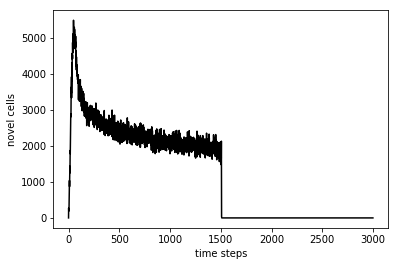

In [27]:
plt.plot(g.nnovelcells[:3000],'black')
plt.xlabel('time steps')
plt.ylabel('novel cells')

### 8.5 Some post processing of run

In [ ]:
# display colors used in colorfunction 10 activities mode size (once "p" pressed)
i= 0;
for colr in [0x800000FF, 0xE40000FF, 0xFF4A00FF, 0xFFAD00FF, 0xECFF13FF, 0x87FF78FF, 0x23FFDCFF, 0x00BDFFFF, 0x005AFFFF, 0x0000F5FF, 0x00008FFF]:
    g.pg.draw.rect(g.scr,colr,[i,i,20,20])
    i=i+20
g.pg.transform.scale2xact(g.scr,g.screen)
g.pg.display.update() 

In [ ]:
maxsmallpatts = 65536
# smallpattdtype defined in genelife_update_module.py
# smallpattdtype=[('topactivity',c_uint32),('activity',c_uint32),('firsttime',c_uint32),('lasttime',c_uint32)]
# print g.genelife.smallpattdtype
smallpatts = np.zeros(maxsmallpatts,dtype=g.genelife.smallpattdtype)
nsmallpatts=g.genelife.get_smallpatts(smallpatts)
print 'nsmallpatts',nsmallpatts
# output table of first 100 values
print '   patt size topactivity activity  firsttime  lasttime'
for i in range(1,100):
    if i<=1: log2n = 0
    else: log2n = int(1+np.log2(int(np.sqrt(i-1)))) 
    print " %6d %4d %8d %8d %10d %10d" % (i, log2n, smallpatts[i]['topactivity'], smallpatts[i]['activity'], smallpatts[i]['firsttime'],smallpatts[i]['lasttime'])
histnodes = np.zeros(10)
for i in range(1:len(smallpatts)):
    if (smallpatts[i]['activity']):
        if i<=1: log2n = 0
        else: log2n = int(1+np.log2(int(np.sqrt(i-1))))  
        histnodes[log2n]=histnodes[log2n]+1
for i in range(10):
    print i,'%7d' % histnodes[i],'out of possible 2^',2**(2*i),'-1'

In [ ]:
g.set_params()
g.genelife.initialize(g.runparams,g.simparams)
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

## 9 Selection: Totalistic LUT encoded by gene with variable length encoding

### 9.1 Game of Life with selection==9

In [3]:
#  9 GoL
#  selection=9 sum totalistic LUT with appropriate parameters for survival and genes encoding LUT in variable length direct encoding
#  this case uses the genes to encode the totalistic (s dept) rule tables for birth and survival
#  birth rules are encoded as 1xxx where xxx is sum-1 of live neighbours and survival rules by 0xxx
#  birth is determined by the existence of a 4-bit birth rule somewhere  in the live neighbour genes for current s=1-8
#  survival is determined by the existence of a 4-bit survival rule somewhere  in the live neighbour genes for current s=1-8
#  in an alternative version (see commented line in update_lut_sum) survival is by the central live neighbour gene
#  ncoding may be set (1-7) to require more bits of gene be 1 to turn on a rule
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=1; # simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
g.repscheme = g.runparams[1] = 0x160         # 1 ignore disambiguation, 7 scissors-paper-stone-well, 0 nbs determine survival, AND of nbs for birth and survival, most difft chosen
g.selection = g.runparams[2] = 9             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0x00      # mask of bits to overwrite if birth allowed and already occupied for bit position sum s
g.survivalmask = g.runparams[4] = 0x06       # 8 bit survival mask for allowing genes to modify LUTs
g.birthmask = g.runparams[7] = 0x04          # 8 bit birth mask for allowing genes to modify LUTs
g.ancselectmask = g.runparams[8] = 0xff      # genetic selection rather than position dependence determines ancestor for all s
g.colorfunction = g.runparams[5] = 12        # initial color function : use arrow keys to update
g.initfield = g.runparams[6] = 100           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  8192   # initial 1 density in GOL state, 16384 = nearest to half of C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 0       # initial density of random genes
g.ncoding = g.simparams[3] = 0x1             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7
g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
# step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

### 9.2 Scissors-paper-stone-well selection with selection==9

* standard subselection mode 7 (repscheme 170) 
* population of gliders with long term cooperation 

In [12]:
#  9 
#  selection=9 sum totalistic LUT with appropriate parameters for survival and genes encoding LUT in variable length direct encoding
#  this case uses the genes to encode the totalistic (s dept) rule tables for birth and survival
#  birth rules are encoded as 1xxx where xxx is sum-1 of live neighbours and survival rules by 0xxx
#  birth is determined by the existence of a 4-bit birth rule somewhere  in the live neighbour genes for current s=1-8
#  survival is determined by the existence of a 4-bit survival rule somewhere  in the live neighbour genes for current s=1-8
#  in an alternative version (see commented line in update_lut_sum) survival is by the central live neighbour gene
#  ncoding may be set (1-7) to require more bits of gene be 1 to turn on a rule
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=1; # simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
g.repscheme = g.runparams[1] = 0x173         # 1 ignore disambiguation, 7 scissors-paper-stone-well, 0 nbs determine survival, AND of nbs for birth and survival, most difft chosen
g.selection = g.runparams[2] = 9             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0x06      # mask of bits to overwrite if birth allowed and already occupied for bit position sum s
g.survivalmask = g.runparams[4] = 0x00       # 8 bit survival mask for allowing genes to modify LUTs
g.birthmask = g.runparams[7] = 0x06          # 8 bit birth mask for allowing genes to modify LUTs
g.ancselectmask = g.runparams[8] = 0xff      # genetic selection rather than position dependence determines ancestor for all s
g.colorfunction = g.runparams[5] = 0         # initial color function : use arrow keys to update
g.initfield = g.runparams[6] = 100           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 10             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  8192   # initial 1 density in GOL state, 16384 = nearest to half of C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 0       # initial density of random genes
g.ncoding = g.simparams[3] = 0x1             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7
g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
# g.step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

In [ ]:
#  9 
#  selection=9 sum totalistic LUT with appropriate parameters for survival and genes encoding LUT in variable length direct encoding
#  this case uses the genes to encode the totalistic (s dept) rule tables for birth and survival
#  birth rules are encoded as 1xxx where xxx is sum-1 of live neighbours and survival rules by 0xxx
#  birth is determined by the existence of a 4-bit birth rule somewhere  in the live neighbour genes for current s=1-8
#  survival is determined by the existence of a 4-bit survival rule somewhere  in the live neighbour genes for current s=1-8
#  in an alternative version (see commented line in update_lut_sum) survival is by the central live neighbour gene
#  ncoding may be set (1-7) to require more bits of gene be 1 to turn on a rule
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=1; # simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
g.repscheme = g.runparams[1] = 0x208         # 1 ignore disambiguation, 7 scissors-paper-stone-well, 0 nbs determine survival, AND of nbs for birth and survival, most difft chosen
g.selection = g.runparams[2] = 9             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0x2c      # mask of bits to overwrite if birth allowed and already occupied for bit position sum s
g.survivalmask = g.runparams[4] = 0x20       # 8 bit survival mask for allowing genes to modify LUTs
g.birthmask = g.runparams[7] = 0x5c          # 8 bit birth mask for allowing genes to modify LUTs
g.ancselectmask = g.runparams[8] = 0xff      # genetic selection rather than position dependence determines ancestor for all s
g.colorfunction = g.runparams[5] = 0         # initial color function : use arrow keys to update
g.initfield = g.runparams[6] = 0           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  8192   # initial 1 density in GOL state, 16384 = nearest to half of C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 0       # initial density of random genes
g.ncoding = g.simparams[3] = 0x1             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7
g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
# step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

In [ ]:
#  9 
#  selection=9 sum totalistic LUT with appropriate parameters for survival and genes encoding LUT in variable length direct encoding
#  this case uses the genes to encode the totalistic (s dept) rule tables for birth and survival
#  birth rules are encoded as 1xxx where xxx is sum-1 of live neighbours and survival rules by 0xxx
#  birth is determined by the existence of a 4-bit birth rule somewhere  in the live neighbour genes for current s=1-8
#  survival is determined by the existence of a 4-bit survival rule somewhere  in the live neighbour genes for current s=1-8
#  in an alternative version (see commented line in update_lut_sum) survival is by the central live neighbour gene
#  ncoding may be set (1-7) to require more bits of gene be 1 to turn on a rule
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=1; # simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
g.repscheme = g.runparams[1] = 0x208         # 1 ignore disambiguation, 7 scissors-paper-stone-well, 0 nbs determine survival, AND of nbs for birth and survival, most difft chosen
g.selection = g.runparams[2] = 9             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0x2c      # mask of bits to overwrite if birth allowed and already occupied for bit position sum s
g.survivalmask = g.runparams[4] = 0x20       # 8 bit survival mask for allowing genes to modify LUTs
g.birthmask = g.runparams[7] = 0x5c          # 8 bit birth mask for allowing genes to modify LUTs
g.ancselectmask = g.runparams[8] = 0xff      # genetic selection rather than position dependence determines ancestor for all s
g.colorfunction = g.runparams[5] = 0         # initial color function : use arrow keys to update
g.initfield = g.runparams[6] = 0           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  8192   # initial 1 density in GOL state, 16384 = nearest to half of C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 0       # initial density of random genes
g.ncoding = g.simparams[3] = 0x1             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7
g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
# step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

In [ ]:

g.get_shist()

### 9.3 Stable population with occasional propagating waves

* genetically stable population (high flying waves) with room for lots of lower waves.
* propagating fronts look a little like reaction diffusion fronts.  
* propagating fronts may diminish after long time (> ~10k steps)

In [ ]:
#  9 
#  selection=9 sum totalistic LUT with appropriate parameters for survival and genes encoding LUT in variable length direct encoding
#  this case uses the genes to encode the totalistic (s dept) rule tables for birth and survival
#  birth rules are encoded as 1xxx where xxx is sum-1 of live neighbours and survival rules by 0xxx
#  birth is determined by the existence of a 4-bit birth rule somewhere  in the live neighbour genes for current s=1-8
#  survival is determined by the existence of a 4-bit survival rule somewhere  in the live neighbour genes for current s=1-8
#  in an alternative version (see commented line in update_lut_sum) survival is by the central live neighbour gene
#  ncoding may be set (1-7) to require more bits of gene be 1 to turn on a rule
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=1; # simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                             # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
g.repscheme = g.runparams[1] = 0x660 
g.selection = g.runparams[2] = 9             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0         # mask of bits to overwrite if birth allowed and already occupied for bit position sum s
g.survivalmask = g.runparams[4] = 0x01       # 8 bit survival mask for allowing genes to modify LUTs
g.birthmask = g.runparams[7] = 0x0d          # 8 bit birth mask for allowing genes to modify LUTs
g.colorfunction = g.runparams[5] = 0         # color function 0(hash), ≥1(fnal), 2 nongulstate or color gol planes, 3 notgolrul yellow
                                             # 4 activities 5 genealogy steps 6 genealogy temporal 7 activity scaled colors
g.initfield = g.runparams[6] = 150           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 7             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  10000   # initial 1 density in GOL state
                                             # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 10000       # initial density of random genes
g.ncoding = g.simparams[3] = 0x1             # for selection 10, non zero value means grow plane community from 0
                                             # otherwise (selection<10) no of bits used to encode valid connection functions 1-16
                                             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 2       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
# step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

### 9.4 Asymptotic dynamics with 2 time scales

* slow time scale: quasi-static islands
* fast time scale: fast dynamics in between the islands, gradually changing island boundaries.
* mess with `survivalmask` to change nature of islands (e.g. `0xd`, `0x1d`)
* seems to be ongoing evolution on both time scales.
* at `t=25000`, hit `Expanding hash table items at table count 262144`

In [ ]:
#  9 
#  selection=9 sum totalistic LUT with appropriate parameters for survival and genes encoding LUT in variable length direct encoding
#  this case uses the genes to encode the totalistic (s dept) rule tables for birth and survival
#  birth rules are encoded as 1xxx where xxx is sum-1 of live neighbours and survival rules by 0xxx
#  birth is determined by the existence of a 4-bit birth rule somewhere  in the live neighbour genes for current s=1-8
#  survival is determined by the existence of a 4-bit survival rule somewhere  in the live neighbour genes for current s=1-8
#  in an alternative version (see commented line in update_lut_sum) survival is by the central live neighbour gene
#  ncoding may be set (1-7) to require more bits of gene be 1 to turn on a rule
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=1; # simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                             # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
g.repscheme = g.runparams[1] = 0x660 
g.selection = g.runparams[2] = 9             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0         # mask of bits to overwrite if birth allowed and already occupied for bit position sum s
g.survivalmask = g.runparams[4] = 0x03       # 8 bit survival mask for allowing genes to modify LUTs
g.birthmask = g.runparams[7] = 0x0d          # 8 bit birth mask for allowing genes to modify LUTs
g.colorfunction = g.runparams[5] = 0         # color function 0(hash), ≥1(fnal), 2 nongulstate or color gol planes, 3 notgolrul yellow
                                             # 4 activities 5 genealogy steps 6 genealogy temporal 7 activity scaled colors
g.initfield = g.runparams[6] = 150           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 7             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  10000   # initial 1 density in GOL state
                                             # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 10000       # initial density of random genes
g.ncoding = g.simparams[3] = 0x1             # for selection 10, non zero value means grow plane community from 0
                                             # otherwise (selection<10) no of bits used to encode valid connection functions 1-16
                                             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 2       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
# step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

with `survivalmask = 0x9d`:

In [ ]:
#  9 
#  selection=9 sum totalistic LUT with appropriate parameters for survival and genes encoding LUT in variable length direct encoding
#  this case uses the genes to encode the totalistic (s dept) rule tables for birth and survival
#  birth rules are encoded as 1xxx where xxx is sum-1 of live neighbours and survival rules by 0xxx
#  birth is determined by the existence of a 4-bit birth rule somewhere  in the live neighbour genes for current s=1-8
#  survival is determined by the existence of a 4-bit survival rule somewhere  in the live neighbour genes for current s=1-8
#  in an alternative version (see commented line in update_lut_sum) survival is by the central live neighbour gene
#  ncoding may be set (1-7) to require more bits of gene be 1 to turn on a rule
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=1; # simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                             # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
g.repscheme = g.runparams[1] = 0x660 
g.selection = g.runparams[2] = 9             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0         # mask of bits to overwrite if birth allowed and already occupied for bit position sum s
g.survivalmask = g.runparams[4] = 0x1d       # 8 bit survival mask for allowing genes to modify LUTs
g.birthmask = g.runparams[7] = 0x0d          # 8 bit birth mask for allowing genes to modify LUTs
g.colorfunction = g.runparams[5] = 0         # color function 0(hash), ≥1(fnal), 2 nongulstate or color gol planes, 3 notgolrul yellow
                                             # 4 activities 5 genealogy steps 6 genealogy temporal 7 activity scaled colors
g.initfield = g.runparams[6] = 150           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 7             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  10000   # initial 1 density in GOL state
                                             # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 10000       # initial density of random genes
g.ncoding = g.simparams[3] = 0x1             # for selection 10, non zero value means grow plane community from 0
                                             # otherwise (selection<10) no of bits used to encode valid connection functions 1-16
                                             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 2       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
# step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

In [ ]:
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

### 9.5 Long interesting transient

Ends with interesting variegated static cruft, with evolutionarily stable dynamics between.

In [ ]:
#  9 
#  selection=9 sum totalistic LUT with appropriate parameters for survival and genes encoding LUT in variable length direct encoding
#  this case uses the genes to encode the totalistic (s dept) rule tables for birth and survival
#  birth rules are encoded as 1xxx where xxx is sum-1 of live neighbours and survival rules by 0xxx
#  birth is determined by the existence of a 4-bit birth rule somewhere  in the live neighbour genes for current s=1-8
#  survival is determined by the existence of a 4-bit survival rule somewhere  in the live neighbour genes for current s=1-8
#  in an alternative version (see commented line in update_lut_sum) survival is by the central live neighbour gene
#  ncoding may be set (1-7) to require more bits of gene be 1 to turn on a rule
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=1; # simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                             # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
g.repscheme = g.runparams[1] = 0x660 
g.selection = g.runparams[2] = 9             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0         # for selection=9 this is the birth mask
g.survivalmask = g.runparams[4] = 0xff       # 8 bit survival mask for allowing genes to modify LUTs
g.birthmask = g.runparams[7] = 0x0a          # 8 bit birth mask for allowing genes to modify LUTs
g.colorfunction = g.runparams[5] = 0         # color function: can be changed up to 12 with arrow keys
g.initfield = g.runparams[6] = 100           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 7             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  10000  # initial 1 density in GOL state: 16384 = nearest to half of C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 10000   # initial density of random genes
g.ncoding = g.simparams[3] = 0x1             # not used for selection 9
g.startgenechoice = g.simparams[4] = 2       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
# step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

In [ ]:
g.set_params()
g.genelife.initialize(g.runparams,g.simparams)
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

### 9.6 Daptics optimized glider parameters

The Daptics run optimizing (glider count) / (nr of live cells)^2 yielded this

In [ ]:
#  9 Daptics optimized parameters for gliders
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=1; # simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
g.repscheme = g.runparams[1] =    0x1c4      # 1 ignore disambiguation, 7 scissors-paper-stone-well, 0 nbs determine survival, AND of nbs for birth and survival, most difft chosen
g.selection = g.runparams[2] = 9             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.survivalmask = g.runparams[4] =  0x84      # 8 bit survival mask for allowing genes to modify LUTs
g.birthmask = g.runparams[7] =     0x92      # 8 bit birth mask for allowing genes to modify LUTs
g.overwritemask = g.runparams[3] = 0x2c      # mask of bits to overwrite if birth allowed and already occupied for bit position sum s
g.ancselectmask = g.runparams[8] = 0xff      # genetic selection rather than position dependence determines ancestor for all s
g.colorfunction = g.runparams[5] = 0         # initial color function : use arrow keys to update
g.initfield = g.runparams[6] = 0           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 5             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  8192   # initial 1 density in GOL state, 16384 = nearest to half of C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 0       # initial density of random genes
g.ncoding = g.simparams[3] = 0x1             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7
g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

Note that this can be simplifed to the following, withut major eeffect on dynamics, adding s=3 birth is then interesting

In [ ]:
#  9 Daptics optimized parameters for gliders
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=1; # simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
g.repscheme = g.runparams[1] =    0x1c0      # 1 ignore disambiguation, 7 scissors-paper-stone-well, 0 nbs determine survival, AND of nbs for birth and survival, most difft chosen
g.selection = g.runparams[2] = 9             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.survivalmask = g.runparams[4] =  0x00      # 8 bit survival mask for allowing genes to modify LUTs
g.birthmask = g.runparams[7] =     0x02      # 8 bit birth mask for allowing genes to modify LUTs
g.overwritemask = g.runparams[3] = 0x00      # mask of bits to overwrite if birth allowed and already occupied for bit position sum s
g.ancselectmask = g.runparams[8] = 0xff      # genetic selection rather than position dependence determines ancestor for all s
g.colorfunction = g.runparams[5] = 0         # initial color function : use arrow keys to update
g.initfield = g.runparams[6] = 100           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 5             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  8192   # initial 1 density in GOL state, 16384 = nearest to half of C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 0       # initial density of random genes
g.ncoding = g.simparams[3] = 0x1             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7
g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

### 9.6a Daptics optimized run parameters from 24.9.2019

In [ ]:
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=1; # simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
g.selection = g.runparams[2] = 9             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code

#fitness =  190832.0 surv 0xe birth 0xfc over 0xd0 rep 0x1b9
#fitness =  63537.9 surv 0x2b birth 0xdd over 0xcd rep 0x1c5
#fitness =  12271.6 surv 0x69 birth 0x39 over 0xa2 rep 0x1ec
#fitness =  19211.1 surv 0xbb birth 0xae over 0x40 rep 0x1cb
#fitness =  118925.8 surv 0x72 birth 0xda over 0x9f rep 0x111

g.survivalmask = g.runparams[4] =  0x0e      # 8 bit survival mask for allowing genes to modify LUTs
g.birthmask = g.runparams[7] =     0xfc      # 8 bit birth mask for allowing genes to modify LUTs
g.overwritemask = g.runparams[3] = 0xd0      # mask of bits to overwrite if birth allowed and already occupied for bit position sum s
g.repscheme = g.runparams[1] =    0x1b9      # 1 ignore disambiguation, 11 long glider periods, 0 nbs determine survival, AND of nbs for birth and survival, most difft chosen

g.ancselectmask = g.runparams[8] = 0xff      # genetic selection rather than position dependence determines ancestor for all s
g.colorfunction = g.runparams[5] = 0         # initial color function : use arrow keys to update
g.initfield = g.runparams[6] = 0             # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  8192   # initial 1 density in GOL state, 16384 = nearest to half of C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 0       # initial density of random genes
g.ncoding = g.simparams[3] = 0x1             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

### 9.7 Test of issue 27

In [ ]:
#  9 Corrected an issue #27 in github : caused by random gene disambiguation not recording ancestor as rootgene
#  selection=9 sum totalistic LUT with appropriate parameters for survival and genes encoding LUT in variable length direct encoding
#  this case uses the genes to encode the totalistic (s dept) rule tables for birth and survival
#  birth rules are encoded as 1xxx where xxx is sum-1 of live neighbours and survival rules by 0xxx
#  birth is determined by the existence of a 4-bit birth rule somewhere  in the live neighbour genes for current s=1-8
#  survival is determined by the existence of a 4-bit survival rule somewhere  in the live neighbour genes for current s=1-8
#  in an alternative version (see commented line in update_lut_sum) survival is by the central live neighbour gene
#  ncoding may be set (1-7) to require more bits of gene be 1 to turn on a rule
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=1; # simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
g.repscheme = g.runparams[1] = 0x770         # 1 ignore disambiguation, 7 scissors-paper-stone-well, 0 nbs determine survival, AND of nbs for birth and survival, most difft chosen
g.selection = g.runparams[2] = 9             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0x06      # mask of bits to overwrite if birth allowed and already occupied for bit position sum s
g.survivalmask = g.runparams[4] = 0x00       # 8 bit survival mask for allowing genes to modify LUTs
g.birthmask = g.runparams[7] = 0x06          # 8 bit birth mask for allowing genes to modify LUTs
g.ancselectmask = g.runparams[8] = 0xff      # genetic selection rather than position dependence determines ancestor for all s
g.colorfunction = g.runparams[5] = 0         # initial color function : use arrow keys to update
g.initfield = g.runparams[6] = 100           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  8192   # initial 1 density in GOL state, 16384 = nearest to half of C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 0       # initial density of random genes
g.ncoding = g.simparams[3] = 0x1             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7
g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
g.step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False,10)
g.repscheme = g.runparams[1] = 0x760
g.genelife.set_repscheme(g.repscheme)
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

### 9.8 Issue 31

In [ ]:
#  8  test of Issue 31
#  selection=8 sum totalistic LUT with appropriate parameters for survival and genes encoding LUt in fixed length direct encoding
#  this case uses the genes to encode the totalistic (s dept) rule tables for birth and survival
#  birth is determined by the and of the live neighbour genes (bits 8-15 for ncoding=1) ie genecode
#  survival is determined the and of the live neighbour genes (bits 0-8 for ncoding=1) ie genecode
#  in an alternative version (see commented line in update_lut_sum) survival is by the central live neighbour gene
#  ncoding may be set (1-7) to require more bits of gene be 1 to turn on a rule
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=1; # simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                             # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
g.repscheme = g.runparams[1] = 0x548         # 
g.selection = g.runparams[2] = 9             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0x75     # mask of bits to overwrite if birth allowed and already occupied for bit position sum s
g.survivalmask = g.runparams[4] = 0x88        # GoL constraint if genes stay active
g.birthmask = g.runparams[7] = 0x45          # GoL constraint if genes stay active 
g.ancselectmask = g.runparams[8] = 0xff      # Allow ancestor selection on all s values for which birth is allowed 
g.colorfunction = g.runparams[5] = 0         # color function: use arrow keys to select 0-12
g.initfield = g.runparams[6] = 0           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 4             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  8192   # initial 1 density in GOL state
                                             # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 0       # initial density of random genes
g.ncoding = g.simparams[3] = 0x1             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
#g.step()
#g.step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

### 9.9 Genetic displacement selection

click button to change repscheme to 0x1f0 after simulation starts

In [ ]:
#  9 
#  selection=9 sum totalistic LUT with appropriate parameters for survival and genes encoding LUT in variable length direct encoding
#  this case uses the genes to encode the totalistic (s dept) rule tables for birth and survival
#  birth rules are encoded as 1xxx where xxx is sum-1 of live neighbours and survival rules by 0xxx
#  birth is determined by the existence of a 4-bit birth rule somewhere  in the live neighbour genes for current s=1-8
#  survival is determined by the existence of a 4-bit survival rule somewhere  in the live neighbour genes for current s=1-8
#  in an alternative version (see commented line in update_lut_sum) survival is by the central live neighbour gene
#  ncoding may be set (1-7) to require more bits of gene be 1 to turn on a rule
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=1; # simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
g.repscheme = g.runparams[1] = 0x170         # 1 ignore disambiguation, 7 scissors-paper-stone-well, 0 nbs determine survival, AND of nbs for birth and survival, most difft chosen
g.selection = g.runparams[2] = 9             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0x06      # mask of bits to overwrite if birth allowed and already occupied for bit position sum s
g.survivalmask = g.runparams[4] = 0x00       # 8 bit survival mask for allowing genes to modify LUTs
g.birthmask = g.runparams[7] = 0x06          # 8 bit birth mask for allowing genes to modify LUTs
g.ancselectmask = g.runparams[8] = 0xff      # genetic selection rather than position dependence determines ancestor for all s
g.colorfunction = g.runparams[5] = 0         # initial color function : use arrow keys to update
g.initfield = g.runparams[6] = 100           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  8192   # initial 1 density in GOL state, 16384 = nearest to half of C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 0       # initial density of random genes
g.ncoding = g.simparams[3] = 0x1             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7
g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
# g.step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

### 9.10 Issue raised in connection with Daptics-optimized parameters

In [ ]:
#  9 
#  selection=9 sum totalistic LUT with appropriate parameters for survival and genes encoding LUT in variable length direct encoding
#  this case uses the genes to encode the totalistic (s dept) rule tables for birth and survival
#  birth rules are encoded as 1xxx where xxx is sum-1 of live neighbours and survival rules by 0xxx
#  birth is determined by the existence of a 4-bit birth rule somewhere  in the live neighbour genes for current s=1-8
#  survival is determined by the existence of a 4-bit survival rule somewhere  in the live neighbour genes for current s=1-8
#  in an alternative version (see commented line in update_lut_sum) survival is by the central live neighbour gene
#  ncoding may be set (1-7) to require more bits of gene be 1 to turn on a rule

g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=1; # simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
g.selection = g.runparams[2] = 9             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code

#fitness =  190832.0 surv 0xe birth 0xfc over 0xd0 rep 0x1b9

g.survivalmask = g.runparams[4] =  0x0e      # 8 bit survival mask for allowing genes to modify LUTs
g.birthmask = g.runparams[7] =     0xfc      # 8 bit birth mask for allowing genes to modify LUTs
g.overwritemask = g.runparams[3] = 0xd0      # mask of bits to overwrite if birth allowed and already occupied for bit position sum s
g.repscheme = g.runparams[1] =    0x1b0      # 1 ignore disambiguation, 11 long glider periods, 0 nbs determine survival, AND of nbs for birth and survival, most difft chosen

g.ancselectmask = g.runparams[8] = 0xff      # genetic selection rather than position dependence determines ancestor for all s
g.colorfunction = g.runparams[5] = 0         # initial color function : use arrow keys to update
g.initfield = g.runparams[6] = 0             # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  16384   # initial 1 density in GOL state, 16384 = nearest to half of C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 8192       # initial density of random genes
g.ncoding = g.simparams[3] = 0x1             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
# g.step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

## 10 Selection: Distance distinguishing LUT encoded by gene with fixed length positional encoding

### 10.1 Game of Life with selection==10

In [4]:
# 10 GoL
#  selection=10 LUT with appropriate parameters for survival
#  this case uses the genes to encode the se (number of live edge-centred sites) and s dept rule tables for birth and survival
#  a fixed positional encoding is used in the gene with 1 bit per valid s,se combination
#  there are 1,2,3,4,5,4,3,2,1 configurations of se for s=0-8. Only 23 cases s=1-7 are lut allowed non-zero.
#  birth is determined by the and of the live neighbour genes (and 23 bits of birthmask) ie genecode
#  survival is determined the and of the live neighbour genes (and 23 bits of survivalmask) ie genecode
#  ncoding not used : only space for 1 bit per lut entry
#  this example starts with only allowing GoL configurations : extend by adding more bits to survival and birth masks
g.nrun=4; g.ndisp=1000; g.nskip=0; g.niter=1;# simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 0x1             # 0,1 whether to allow GoL rule modifications
g.repscheme = g.runparams[1] = 0x610         
g.selection     = g.runparams[2] = 10        # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0x00      # mask of bits to overwrite if birth allowed and already occupied for bit position sum s
g.birthmask    = g.runparams[7] = 0x000001e0 # for selection=10-11 this is the GoL birth mask
g.survivalmask = g.runparams[4] = 0x000001fc # for selection=10-11 this is the GoL survival mask
g.ancselectmask = g.runparams[8] = 0xff      # ancestor mask allowing selection for all s values
g.colorfunction = g.runparams[5] = 0         # color function can be cahnged with arrow keys
g.initfield = g.runparams[6] = 150           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] = 8192    # initial 1 density in GOL state: 16384 = nearest to half of C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 0       # initial density of random genes
g.ncoding = g.simparams[3] = 0               # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
#g.step(True)
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

### 10.2 Scissors-paper-stone-well selection with selection==10

In [13]:
## 10
#  selection=10 LUT with appropriate parameters for survival
#  this case uses the genes to encode the se (number of live edge-centred sites) and s dept rule tables for birth and survival
#  a fixed positional encoding is used in the gene with 1 bit per valid s,se combination
#  there are 1,2,3,4,5,4,3,2,1 configurations of se for s=0-8. Only 23 cases s=1-7 are lut allowed non-zero.
#  birth is determined by the and of the live neighbour genes (and 23 bits of birthmask) ie genecode
#  survival is determined the and of the live neighbour genes (and 23 bits of survivalmask) ie genecode
#  ncoding not used : only space for 1 bit per lut entry
#  this example starts with only allowing GoL configurations : extend by adding more bits to survival and birth masks
g.nrun=4; g.ndisp=1000; g.nskip=0; g.niter=1;# simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 0x1             # 0,1 whether to allow GoL rule modifications
g.repscheme = g.runparams[1] = 0x170         
g.selection     = g.runparams[2] = 10        # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0x06      # mask of bits to overwrite if birth allowed and already occupied for bit position sum s
g.birthmask    = g.runparams[7] = 0x000001fc # for selection=10-11 this is the GoL birth mask with birth for s=2 added
g.survivalmask = g.runparams[4] = 0x0        # for selection=10-11 this is the GoL survival mask
g.ancselectmask = g.runparams[8] = 0xff      # ancestor mask allowing selection for all s values
g.colorfunction = g.runparams[5] = 0         # color function can be cahnged with arrow keys
g.initfield = g.runparams[6] = 100           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] = 8192    # initial 1 density in GOL state: 16384 = nearest to half of C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 0       # initial density of random genes
g.ncoding = g.simparams[3] = 0               # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
#g.step(True)
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

In [ ]:
# g.set_params()
g.genelife.initialize(g.runparams,g.simparams)
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

### 10.3 Test of symmetry breaking expansion of rules

In [12]:
#  10 
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=1; # simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
g.repscheme = g.runparams[1] = 0x150         # 0 defaults 6 penalizes too many rules 1 trivial disambiguation
g.selection = g.runparams[2] = 10             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0xff      # mask of bits to overwrite if birth allowed and already occupied for bit position sum s
g.survivalmask = g.runparams[4] = 0x00       # GoL constraint if genes stay active
g.birthmask = g.runparams[7] = 0x1fc          # GoL constraint if genes stay active 
g.ancselectmask = g.runparams[8] = 0xff      # Allow ancestor selection on all s values for which birth is allowed 
g.colorfunction = g.runparams[5] = 0         # color function: choose 0-12 using arrows
g.initfield = g.runparams[6] = 0             # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  8192   # initial 1 density in GOL state: 16384 = nearest to half of  C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 16384       # initial density of random genes
g.ncoding = g.simparams[3] = 0x1             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
#g.step()
#g.step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

step 0 pixel data (218,418) gol 0 gene 0000000000000000 status 0000000000000000
step 1506 birthmask changed to 1ec
step 2003 birthmask changed to 1fc
step 2506 birthmask changed to 1f8
step 3006 birthmask changed to 1fc
step 3528 birthmask changed to 1f8
step 3542 birthmask changed to 1e8
step 3685 birthmask changed to 1f8
step 3705 birthmask changed to 1fc
step 4005 birthmask changed to 1f4
step 5016 collected trace of nnovelcells


Text(0, 0.5, 'novel cells')

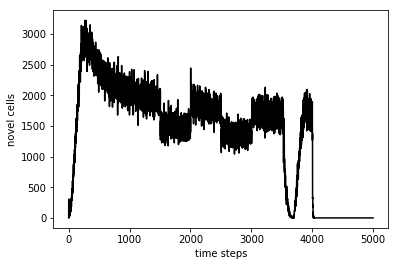

In [13]:
plt.plot(g.nnovelcells[:5000],'black')
plt.xlabel('time steps')
plt.ylabel('novel cells')

## 11 Selection: Distance distinguishing LUT encoded by gene with variable length encoding

### 11.1 Game of Life with selection==11

In [ ]:
(s,se)
s=4 5 states (0 to 4 edge states)
s=3 4 states (0 to 3 edge states)
s=2 3 states (both corner, both edge, corner+edge)
s=1 2 status (corner nbr)

In [5]:
# 11
#  selection=11 LUT with appropriate parameters for survival
#  this case uses the genes to encode the se (number of live edge-centred sites) and s dept rule tables for birth and survival
#  a variable length encoding is used in the gene with 4+4 bits, 4-bits for the survival and birth s value as in 8, and 4 bits for the se value
#  there are 1,2,3,4,5,4,3,2,1 configurations of se for s=0-8. Only 19 cases s=2-6 are lut allowed non-zero.
#  birth is determined by the and of the live neighbour genes (and 19 bits of overwritemask) ie genecode
#  survival is determined the and of the live neighbour genes (and 19 bits of survivalmask) ie genecode
#  ncoding not used : only space for 1 bit per lut entry
#  this example starts with only allowing GoL configurations : extend by adding more bits to survival and birth masks
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=1;# simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                             # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
g.repscheme = g.runparams[1] = 0x0610        # 
g.selection     = g.runparams[2] = 11        # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0x00      # no overwrite allowed in this version, alternatively set to 0x04 for overwrite on s=3 birth
g.survivalmask = g.runparams[4] = 0x000001fc # for selection=10-11 this is the GoL survival mask
g.birthmask    = g.runparams[7] = 0x000001e0 # for selection=10-11 this is the GoL birth mask
g.ancselectmask = g.runparams[8] = 0xff       # ancestor mask allowing selection for all s values
g.colorfunction = g.runparams[5] = 0         # color function 0(hash), ≥1(fnal), 2 nongulstate or color gol planes, 3 notgolrul yellow
                                             # 4 activities 5 genealogy steps 6 genealogy temporal 7 activity scaled colors
g.initfield = g.runparams[6] = 100           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  16384  # initial 1 density in GOL state
                                             # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 0       # initial density of random genes
g.ncoding = g.simparams[3] = 0               # for selection 10, non zero value means grow plane community from 0
                                             # otherwise (selection<10) no of bits used to encode valid connection functions 1-16
                                             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
# step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

### 11.2 Scissors-paper-stone-well selection with selection==11

In [14]:
## 11 Scissor-Paper-Stone-Well
#  selection=11 LUT with appropriate parameters for survival
#  this case uses the genes to encode the se (number of live edge-centred sites) and s dept rule tables for birth and survival
#  a fixed positional encoding is used in the gene with 1 bit per valid s,se combination
#  there are 1,2,3,4,5,4,3,2,1 configurations of se for s=0-8. Only 23 cases s=1-7 are lut allowed non-zero.
#  birth is determined by the and of the live neighbour genes (and 23 bits of birthmask) ie genecode
#  survival is determined the and of the live neighbour genes (and 23 bits of survivalmask) ie genecode
#  ncoding not used : only space for 1 bit per lut entry
#  this example starts with only allowing GoL configurations : extend by adding more bits to survival and birth masks
g.nrun=4; g.ndisp=1000; g.nskip=0; g.niter=1;# simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 0x1             # 0,1 whether to allow GoL rule modifications
g.repscheme = g.runparams[1] = 0x170         
g.selection     = g.runparams[2] = 11        # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0x06      # mask of bits to overwrite if birth allowed and already occupied for bit position sum s
g.birthmask    = g.runparams[7] = 0x01fc     # for selection=10-11 this is the GoL birth mask with birth for s=2 added
g.survivalmask = g.runparams[4] = 0x0        # for selection=10-11 this is the GoL survival mask
g.ancestormask = g.runparams[8] = 0xff       # ancestor mask allowing selection for all cases
g.colorfunction = g.runparams[5] = 0         # color function can be cahnged with arrow keys
g.initfield = g.runparams[6] = 150           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] = 8192    # initial 1 density in GOL state: 16384 = nearest to half of C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 0       # initial density of random genes
g.ncoding = g.simparams[3] = 0               # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
#g.step(True)
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

### Deterministic simulation with 0 mutation

In [4]:
## 11 Scissor-Paper-Stone-Well
#  selection=11 LUT with appropriate parameters for survival
#  this case uses the genes to encode the se (number of live edge-centred sites) and s dept rule tables for birth and survival
#  a fixed positional encoding is used in the gene with 1 bit per valid s,se combination
#  there are 1,2,3,4,5,4,3,2,1 configurations of se for s=0-8. Only 23 cases s=1-7 are lut allowed non-zero.
#  birth is determined by the and of the live neighbour genes (and 23 bits of birthmask) ie genecode
#  survival is determined the and of the live neighbour genes (and 23 bits of survivalmask) ie genecode
#  ncoding not used : only space for 1 bit per lut entry
#  this example starts with only allowing GoL configurations : extend by adding more bits to survival and birth masks
g.nrun=4; g.ndisp=1000; g.nskip=0; g.niter=1;# simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 0x1             # 0,1 whether to allow GoL rule modifications
g.repscheme = g.runparams[1] = 0x170         
g.selection     = g.runparams[2] = 11        # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0x06      # mask of bits to overwrite if birth allowed and already occupied for bit position sum s
g.birthmask    = g.runparams[7] = 0x01fc     # for selection=10-11 this is the GoL birth mask with birth for s=2 added
g.survivalmask = g.runparams[4] = 0x0        # for selection=10-11 this is the GoL survival mask
g.ancestormask = g.runparams[8] = 0xff       # ancestor mask allowing selection for all cases
g.colorfunction = g.runparams[5] = 0         # color function can be cahnged with arrow keys
g.initfield = g.runparams[6] = 150           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 0             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] = 8192    # initial 1 density in GOL state: 16384 = nearest to half of C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 0       # initial density of random genes
g.ncoding = g.simparams[3] = 0               # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
#g.step(True)
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

step 0 pixel data (0,0) gol 0 gene 0000000000000000 status 0000000000000000
step 372 colorfunction2 changed to 0
step 624 colorfunction2 changed to 1
step 636 colorfunction2 changed to 2
step 676 colorfunction2 changed to 1
step 684 colorfunction2 changed to 0
step 696 colorfunction2 changed to -1
step 708 colorfunction2 changed to 12
step 720 colorfunction2 changed to 11
step 744 colorfunction2 changed to 10
step 752 colorfunction2 changed to 9
step 1016 noveltyfilter changed to  1
step 1016 noveltyfilter changed to  0
image saved ./images/genelife_sel11_t1016_r00000170_s000_c09.jpeg
step 1016 noveltyfilter changed to  1
image saved ./images/genelife_sel11_t1016_r00000170_s001_c09.jpeg
image saved ./images/genelife_sel11_t1016_r00000170_s002_c00.jpeg
step 1016 colorfunction changed to 1
step 1016 colorfunction changed to 2
image saved ./images/genelife_sel11_t1016_r00000170_s003_c02.jpeg
step 1016 colorfunction changed to 3
step 1016 colorfunction changed to 4
step 1016 colorfunction 

In [ ]:
## g.set_params()
g.genelife.initialize(g.runparams,g.simparams)
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

### 11.3 Test of issue 24

In [ ]:
## 11
#  selection=11 test of issue 24
g.nrun=4; g.ndisp=1000; g.nskip=0; g.niter=1;# simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 0x1             # 0,1 whether to allow GoL rule modifications
g.repscheme = g.runparams[1] = 0x400         
g.selection     = g.runparams[2] = 11        # 
g.overwritemask = g.runparams[3] = 0x00      # 
g.birthmask    = g.runparams[7] = 0x00000da  # 
g.survivalmask = g.runparams[4] = 0x0        # 
g.ancselectmask = g.runparams[8] = 0xff      # ancestor mask allowing selection for all s values
g.colorfunction = g.runparams[5] = 0         # color function can be cahnged with arrow keys
g.initfield = g.runparams[6] = 150           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] = 10000   # initial 1 density in GOL state: 16384 = nearest to half of C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 10000       # initial density of random genes
g.ncoding = g.simparams[3] = 0               # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
#g.step(True)
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

### 11.4 Simple interesting case : 2/3 of the 3 birth sum 2 LUT entries allowed, nothing else
Initiate with GOL masks B 0x1e0 and S 0x1fc and then add top two sum=2 birth LUT entries 
Then take away all survival entries and then all sum=3 birth entries from masks, leaving a short time for the correct genes to be found.
Alternatively, start straight with final masks and do random gene initialization not GoL genes.
The colorfunction 1 detects whole rule entries, and partial GoL rules, and bunches related functions more than colorfunction 0.
Include new example 12.1 to illustrate the power of distinctions : in this case suppressing the all corner case of birth with sum=2.
This is a world of gliders close to that observed in selection 1,2.

In [ ]:
# 11
#  selection=11 LUT with appropriate parameters for survival
#  this case uses the genes to encode the se (number of live edge-centred sites) and s dept rule tables for birth and survival
#  a variable length encoding is used in the gene with 4+4 bits, 4-bits for the survival and birth s value as in 8, and 4 bits for the se value
#  there are 1,2,3,4,5,4,3,2,1 configurations of se for s=0-8. Only 19 cases s=2-6 are lut allowed non-zero.
#  birth is determined by the and of the live neighbour genes (and 19 bits of overwritemask) ie genecode
#  survival is determined the and of the live neighbour genes (and 19 bits of survivalmask) ie genecode
#  ncoding not used : only space for 1 bit per lut entry
#  this example starts with only allowing GoL configurations : extend by adding more bits to survival and birth masks
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=1;# simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                             # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
g.repscheme = g.runparams[1] = 0x080         # repscheme bit 3 (val 0x8) determines whether random choice of ancestor amongst live neighbours
                                             # repscheme mod 8 i.e. 0-7 determines selection scheme based on gene
                                             # 0 minimum gene as value  # 1 maximum gene as value
                                             # 2 minimum number of ones # 3 maximum number of ones
                                             # 4 neutral selection # 5 neutral but different selection
                                             # 6 penalty function -1 for a survival rule -2 for a birth rule  # 7 not allowed 
g.selection     = g.runparams[2] = 11        # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0x00
g.birthmask    = g.runparams[7] = 0x00000018 # for selection=10-13 this is the GoL birth mask
g.survivalmask = g.runparams[4] = 0x00000000 # for selection=10-11 this is the GoL survival mask
g.colorfunction = g.runparams[5] = 1         # color function 0(hash), ≥1(fnal), 2 nongulstate or color gol planes, 3 notgolrul yellow
                                             # 4 activities 5 genealogy steps 6 genealogy temporal 7 activity scaled colors
g.initfield = g.runparams[6] = 100           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  16384  # initial 1 density in GOL state
                                             # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 32768       # initial density of random genes
g.ncoding = g.simparams[3] = 0               # for selection 10, non zero value means grow plane community from 0
                                             # otherwise (selection<10) no of bits used to encode valid connection functions 1-16
                                             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
# step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

### 11.5 Long evolving transient to sea of simple gliders

* Initial condition density critical to get a seed that doesn't die.
* Final state seems evolutionarily stable (invasions of mutations are very rare, new waves die out).
* Even "R" periodic perturbation does not perturb final state, genetically.  In 
fact, it seems to stabilize it.
* Final state has 1-d fractal triangle space time cross section (see below).

**Could the interacting gliders be "performing a computation"?  If yes, we have a case of evolution to computation.**

In [ ]:
# 11
#  selection=11 LUT with appropriate parameters for survival
#  this case uses the genes to encode the se (number of live edge-centred sites) and s dept rule tables for birth and survival
#  a variable length encoding is used in the gene with 4+4 bits, 4-bits for the survival and birth s value as in 8, and 4 bits for the se value
#  there are 1,2,3,4,5,4,3,2,1 configurations of se for s=0-8. Only 23 cases s=1-7 are lut allowed non-zero.
#  birth is determined by the and of the live neighbour genes (and 23 bits of birthmask) ie genecode
#  survival is determined the and of the live neighbour genes (and 19 bits of survivalmask) ie genecode
#  ncoding not used : only space for 1 bit per lut entry
#  this example starts with only allowing GoL configurations : extend by adding more bits to survival and birth masks
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=1;# simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                             # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
g.repscheme = g.runparams[1] = 0x110         # repscheme bit 3 (val 0x8) determines whether random choice of ancestor amongst live neighbours
                                             # repscheme mod 8 i.e. 0-7 determines selection scheme based on gene
                                             # 0 minimum gene as value  # 1 maximum gene as value
                                             # 2 minimum number of ones # 3 maximum number of ones
                                             # 4 neutral selection # 5 neutral but different selection
                                             # 6 penalty function -1 for a survival rule -2 for a birth rule  # 7 not allowed 
g.selection     = g.runparams[2] = 11        # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0x00
g.birthmask    = g.runparams[7] = 0x000000f8 # 
g.survivalmask = g.runparams[4] = 0x0000003f # 
g.colorfunction = g.runparams[5] = 0         # color function 0(hash), ≥1(fnal), 2 nongulstate or color gol planes, 3 notgolrul yellow
                                             # 4 activities 5 genealogy steps 6 genealogy temporal 7 activity scaled colors
g.initfield = g.runparams[6] = 256           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  10000  # initial 1 density in GOL state
                                             # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 10000       # initial density of random genes
g.ncoding = g.simparams[3] = 0               # for selection 10, non zero value means grow plane community from 0
                                             # otherwise (selection<10) no of bits used to encode valid connection functions 1-16
                                             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 7       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
# step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

In [ ]:
# 11
#  selection=11 LUT with appropriate parameters for survival
#  this case uses the genes to encode the se (number of live edge-centred sites) and s dept rule tables for birth and survival
#  a variable length encoding is used in the gene with 4+4 bits, 4-bits for the survival and birth s value as in 8, and 4 bits for the se value
#  there are 1,2,3,4,5,4,3,2,1 configurations of se for s=0-8. Only 23 cases s=1-7 are lut allowed non-zero.
#  birth is determined by the and of the live neighbour genes (and 23 bits of birthmask) ie genecode
#  survival is determined the and of the live neighbour genes (and 19 bits of survivalmask) ie genecode
#  ncoding not used : only space for 1 bit per lut entry
#  this example starts with only allowing GoL configurations : extend by adding more bits to survival and birth masks
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=1;# simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                             # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
g.repscheme = g.runparams[1] = 0x110         # repscheme bit 3 (val 0x8) determines whether random choice of ancestor amongst live neighbours
                                             # repscheme mod 8 i.e. 0-7 determines selection scheme based on gene
                                             # 0 minimum gene as value  # 1 maximum gene as value
                                             # 2 minimum number of ones # 3 maximum number of ones
                                             # 4 neutral selection # 5 neutral but different selection
                                             # 6 penalty function -1 for a survival rule -2 for a birth rule  # 7 not allowed 
g.selection     = g.runparams[2] = 11        # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0x00
g.birthmask    = g.runparams[7] = 0x000000f8 # 
g.survivalmask = g.runparams[4] = 0x0000003f # 
g.colorfunction = g.runparams[5] = 0         # color function 0(hash), ≥1(fnal), 2 nongulstate or color gol planes, 3 notgolrul yellow
                                             # 4 activities 5 genealogy steps 6 genealogy temporal 7 activity scaled colors
g.initfield = g.runparams[6] = 256           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  10000  # initial 1 density in GOL state
                                             # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 10000       # initial density of random genes
g.ncoding = g.simparams[3] = 0               # for selection 10, non zero value means grow plane community from 0
                                             # otherwise (selection<10) no of bits used to encode valid connection functions 1-16
                                             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 7       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()

##################################################
# activity stuff:
g.activity(1000,acttype="all")

In [ ]:
# 11
#  selection=11 LUT with appropriate parameters for survival
#  this case uses the genes to encode the se (number of live edge-centred sites) and s dept rule tables for birth and survival
#  a variable length encoding is used in the gene with 4+4 bits, 4-bits for the survival and birth s value as in 8, and 4 bits for the se value
#  there are 1,2,3,4,5,4,3,2,1 configurations of se for s=0-8. Only 23 cases s=1-7 are lut allowed non-zero.
#  birth is determined by the and of the live neighbour genes (and 23 bits of birthmask) ie genecode
#  survival is determined the and of the live neighbour genes (and 19 bits of survivalmask) ie genecode
#  ncoding not used : only space for 1 bit per lut entry
#  this example starts with only allowing GoL configurations : extend by adding more bits to survival and birth masks
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=1;# simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                             # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
g.repscheme = g.runparams[1] = 0x110         # repscheme bit 3 (val 0x8) determines whether random choice of ancestor amongst live neighbours
                                             # repscheme mod 8 i.e. 0-7 determines selection scheme based on gene
                                             # 0 minimum gene as value  # 1 maximum gene as value
                                             # 2 minimum number of ones # 3 maximum number of ones
                                             # 4 neutral selection # 5 neutral but different selection
                                             # 6 penalty function -1 for a survival rule -2 for a birth rule  # 7 not allowed 
g.selection     = g.runparams[2] = 11        # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0x00
g.birthmask    = g.runparams[7] = 0x000000f8 # 
g.survivalmask = g.runparams[4] = 0x0000003f # 
g.colorfunction = g.runparams[5] = 0         # color function 0(hash), ≥1(fnal), 2 nongulstate or color gol planes, 3 notgolrul yellow
                                             # 4 activities 5 genealogy steps 6 genealogy temporal 7 activity scaled colors
g.initfield = g.runparams[6] = 256           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  10000  # initial 1 density in GOL state
                                             # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 10000       # initial density of random genes
g.ncoding = g.simparams[3] = 0               # for selection 10, non zero value means grow plane community from 0
                                             # otherwise (selection<10) no of bits used to encode valid connection functions 1-16
                                             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 7       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
#

#################################################
# activity stuff:

g.activity(100,maxnum=100000)  # takes a while...

In [ ]:
# 11
#  selection=11 LUT with appropriate parameters for survival
#  this case uses the genes to encode the se (number of live edge-centred sites) and s dept rule tables for birth and survival
#  a variable length encoding is used in the gene with 4+4 bits, 4-bits for the survival and birth s value as in 8, and 4 bits for the se value
#  there are 1,2,3,4,5,4,3,2,1 configurations of se for s=0-8. Only 23 cases s=1-7 are lut allowed non-zero.
#  birth is determined by the and of the live neighbour genes (and 23 bits of birthmask) ie genecode
#  survival is determined the and of the live neighbour genes (and 19 bits of survivalmask) ie genecode
#  ncoding not used : only space for 1 bit per lut entry
#  this example starts with only allowing GoL configurations : extend by adding more bits to survival and birth masks
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=1;# simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                             # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
g.repscheme = g.runparams[1] = 0x110         # repscheme bit 3 (val 0x8) determines whether random choice of ancestor amongst live neighbours
                                             # repscheme mod 8 i.e. 0-7 determines selection scheme based on gene
                                             # 0 minimum gene as value  # 1 maximum gene as value
                                             # 2 minimum number of ones # 3 maximum number of ones
                                             # 4 neutral selection # 5 neutral but different selection
                                             # 6 penalty function -1 for a survival rule -2 for a birth rule  # 7 not allowed 
g.selection     = g.runparams[2] = 11        # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0x00
g.birthmask    = g.runparams[7] = 0x000000f8 # 
g.survivalmask = g.runparams[4] = 0x0000003f # 
g.colorfunction = g.runparams[5] = 0         # color function 0(hash), ≥1(fnal), 2 nongulstate or color gol planes, 3 notgolrul yellow
                                             # 4 activities 5 genealogy steps 6 genealogy temporal 7 activity scaled colors
g.initfield = g.runparams[6] = 256           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  10000  # initial 1 density in GOL state
                                             # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 10000       # initial density of random genes
g.ncoding = g.simparams[3] = 0               # for selection 10, non zero value means grow plane community from 0
                                             # otherwise (selection<10) no of bits used to encode valid connection functions 1-16
                                             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 7       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
#

#################################################
# activity stuff:
g.activity(500,maxnum=2000000)  # takes a while...

### 11.6 Competing blooms -> stationary competition

In [ ]:
# 11
#  selection=11 LUT with appropriate parameters for survival
#  this case uses the genes to encode the se (number of live edge-centred sites) and s dept rule tables for birth and survival
#  a variable length encoding is used in the gene with 4+4 bits, 4-bits for the survival and birth s value as in 8, and 4 bits for the se value
#  there are 1,2,3,4,5,4,3,2,1 configurations of se for s=0-8. Only 23 cases s=1-7 are lut allowed non-zero.
#  birth is determined by the and of the live neighbour genes (and 23 bits of birthmask) ie genecode
#  survival is determined the and of the live neighbour genes (and 19 bits of survivalmask) ie genecode
#  ncoding not used : only space for 1 bit per lut entry
#  this example starts with only allowing GoL configurations : extend by adding more bits to survival and birth masks
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=1;# simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                             # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
g.repscheme = g.runparams[1] = 0x110         # repscheme bit 3 (val 0x8) determines whether random choice of ancestor amongst live neighbours
                                             # repscheme mod 8 i.e. 0-7 determines selection scheme based on gene
                                             # 0 minimum gene as value  # 1 maximum gene as value
                                             # 2 minimum number of ones # 3 maximum number of ones
                                             # 4 neutral selection # 5 neutral but different selection
                                             # 6 penalty function -1 for a survival rule -2 for a birth rule  # 7 not allowed 
g.selection     = g.runparams[2] = 11        # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0x00
g.birthmask    = g.runparams[7] = 0x000000fe # 
g.survivalmask = g.runparams[4] = 0x0000003f # 
g.colorfunction = g.runparams[5] = 0         # color function 0(hash), ≥1(fnal), 2 nongulstate or color gol planes, 3 notgolrul yellow
                                             # 4 activities 5 genealogy steps 6 genealogy temporal 7 activity scaled colors
g.initfield = g.runparams[6] = 256           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  10000  # initial 1 density in GOL state
                                             # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 10000       # initial density of random genes
g.ncoding = g.simparams[3] = 0               # for selection 10, non zero value means grow plane community from 0
                                             # otherwise (selection<10) no of bits used to encode valid connection functions 1-16
                                             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 7       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
# step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

### 11.6 Another long transient, to more complex competitive mix

In [ ]:
# 11
#  selection=11 LUT with appropriate parameters for survival
#  this case uses the genes to encode the se (number of live edge-centred sites) and s dept rule tables for birth and survival
#  a variable length encoding is used in the gene with 4+4 bits, 4-bits for the survival and birth s value as in 8, and 4 bits for the se value
#  there are 1,2,3,4,5,4,3,2,1 configurations of se for s=0-8. Only 23 cases s=1-7 are lut allowed non-zero.
#  birth is determined by the and of the live neighbour genes (and 23 bits of birthmask) ie genecode
#  survival is determined the and of the live neighbour genes (and 19 bits of survivalmask) ie genecode
#  ncoding not used : only space for 1 bit per lut entry
#  this example starts with only allowing GoL configurations : extend by adding more bits to survival and birth masks
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=1;# simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                             # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
g.repscheme = g.runparams[1] = 0x311         # repscheme bit 3 (val 0x8) determines whether random choice of ancestor amongst live neighbours
                                             # repscheme mod 8 i.e. 0-7 determines selection scheme based on gene
                                             # 0 minimum gene as value  # 1 maximum gene as value
                                             # 2 minimum number of ones # 3 maximum number of ones
                                             # 4 neutral selection # 5 neutral but different selection
                                             # 6 penalty function -1 for a survival rule -2 for a birth rule  # 7 not allowed 
g.selection     = g.runparams[2] = 11        # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0x00
g.birthmask    = g.runparams[7] = 0x000000da # 
g.survivalmask = g.runparams[4] = 0x0000003f # 
g.colorfunction = g.runparams[5] = 0         # color function 0(hash), ≥1(fnal), 2 nongulstate or color gol planes, 3 notgolrul yellow
                                             # 4 activities 5 genealogy steps 6 genealogy temporal 7 activity scaled colors
g.initfield = g.runparams[6] = 256           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  10000  # initial 1 density in GOL state
                                             # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 10000       # initial density of random genes
g.ncoding = g.simparams[3] = 0               # for selection 10, non zero value means grow plane community from 0
                                             # otherwise (selection<10) no of bits used to encode valid connection functions 1-16
                                             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 7       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
# step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

In [ ]:
# 11
#  selection=11 LUT with appropriate parameters for survival
#  this case uses the genes to encode the se (number of live edge-centred sites) and s dept rule tables for birth and survival
#  a variable length encoding is used in the gene with 4+4 bits, 4-bits for the survival and birth s value as in 8, and 4 bits for the se value
#  there are 1,2,3,4,5,4,3,2,1 configurations of se for s=0-8. Only 23 cases s=1-7 are lut allowed non-zero.
#  birth is determined by the and of the live neighbour genes (and 23 bits of birthmask) ie genecode
#  survival is determined the and of the live neighbour genes (and 19 bits of survivalmask) ie genecode
#  ncoding not used : only space for 1 bit per lut entry
#  this example starts with only allowing GoL configurations : extend by adding more bits to survival and birth masks
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=1;# simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                             # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
g.repscheme = g.runparams[1] = 0x311         # repscheme bit 3 (val 0x8) determines whether random choice of ancestor amongst live neighbours
                                             # repscheme mod 8 i.e. 0-7 determines selection scheme based on gene
                                             # 0 minimum gene as value  # 1 maximum gene as value
                                             # 2 minimum number of ones # 3 maximum number of ones
                                             # 4 neutral selection # 5 neutral but different selection
                                             # 6 penalty function -1 for a survival rule -2 for a birth rule  # 7 not allowed 
g.selection     = g.runparams[2] = 11        # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0x00
g.birthmask    = g.runparams[7] = 0x000000da # 
g.survivalmask = g.runparams[4] = 0x0000003f # 
g.colorfunction = g.runparams[5] = 0         # color function 0(hash), ≥1(fnal), 2 nongulstate or color gol planes, 3 notgolrul yellow
                                             # 4 activities 5 genealogy steps 6 genealogy temporal 7 activity scaled colors
g.initfield = g.runparams[6] = 256           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  10000  # initial 1 density in GOL state
                                             # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 10000       # initial density of random genes
g.ncoding = g.simparams[3] = 0               # for selection 10, non zero value means grow plane community from 0
                                             # otherwise (selection<10) no of bits used to encode valid connection functions 1-16
                                             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 7       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
# step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

In [ ]:
g.activity(500,maxnum=100000)

In [ ]:
maxngenes = 100000
genes=np.zeros(maxngenes,np.uint64)
activitiesl=np.zeros(maxngenes,np.int32)


N = 100
qqq = [[None]*10 for _ in range(N)]
nsp = [None]*N
g.genelife.genelife_update(1,0,0)
nspecies=g.genelife.get_activities(genes,activitiesl) # live only

for i in range(N):
    ac = [activitiesl[i] for i in range(len(activitiesl)) if activitiesl[i]>1]
    qqq[i] = np.quantile(ac,qq)
    g.genelife.genelife_update(1,0,0)
    nsp[i]=g.genelife.get_activities(genes,activitiesl)

for j in range(10):
    foo = [qqq[i][j] for i in range(N)]
    plt.semilogy(foo)
plt.show()
plt.plot(nsp);

In [ ]:
N=100
nquant=10
acttype="live" # all = all genes, live = live genes only,  quad = quad patterns, small = small patterns
maxnum=100000
init=False
if acttype=="live":
    doact = g.genelife.get_activities
elif acttype=="all":
    doact = g.genelife.get_all_activities
elif acttype=="quad":
    doact = g.genelife.get_quad_activities
else:
    printf("unknown acttype:  ",acttype)

activities = np.zeros(maxnum,np.int32)

data=np.zeros(maxnum,np.uint64)
qqq = [[None]*nquant for _ in range(N)]
qq = [x/nquant for x in range(nquant)]
nspecies = [None]*N

if init:
    g.genelife.initialize_planes(g.npoffsets)
    g.genelife.initialize(g.runparams,g.simparams)
g.genelife.genelife_update(1,0,0)
nspecies[0]=doact(data,activities)

for j in range(1,N):
    ac = [activities[i] for i in range(len(activities)) if activities[i]>1]
    qqq[j] = np.quantile(ac,qq)
    g.genelife.genelife_update(1,0,0)
    nspecies[j]=doact(data,activities)

for j in range(10):
    foo = [qqq[i][j] for i in range(N)]
    plt.semilogy(foo)
plt.show()
plt.plot(nsp);


In [ ]:
g.genelife.get_curgol(g.gol)
cnt = range(g.N)
for i in range(g.N):
    cnt[i] = sum([g.gol[(i*g.N)+j] for j in range(g.N)])

In [ ]:
foo = [(i,cnt[i]) for i in range(g.N) if cnt[i] == max(cnt)]

myrow = foo[0][0]
for i in range(g.N):
    g.genelife.get_curgol(g.gol)
    for j in range(g.N):
        if g.gol[(g.N*myrow)+j]==1:
            g.cgrid[i][j] = 1
        else:
            g.cgrid[i][j] = 0
    g.genelife.genelife_update(1,0,0)
    

In [ ]:
%matplotlib inline

my_dpi=96
my_cmap = g.rand_cmap(257, type='bright', first_color_black=True, last_color_black=False)

fig, ax = g.plt.subplots(figsize=((3*256)/my_dpi, (3*256)/my_dpi), dpi=my_dpi, frameon=False)
ax.axis('off')
# mat = ax.matshow(cgrid, cmap=my_cmap, vmin=0.01, vmax=257)  # was vmax = LEN+1
mat = ax.matshow(g.cgrid, cmap=my_cmap, vmin = 0, vmax = 56)
g.plt.show()

In [ ]:
dir(g)

In [ ]:
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

## 12 Selection: Canonical rotation LUT encoded by gene with fixed length positional encoding

### 12.1 Game of Life with selection==12

In [6]:
# 12 GoL
#  selection=12 LUT with appropriate parameters for survival
#  this case uses the genes to encode the canonical rotation and s dept rule tables for birth and survival
#  a fixed positional encoding is used in the gene with 1-bit for each canonical rotation in the 32 bit survival and birth masks
#  there are 1,1,4,7,10,7,4,1,1 canonical rotation mask bits for s=0-8. Only 32 cases s=2-6 in LUT are allowed non-zero.
#  birth is determined by the and of the live neighbour genes (and 32 bits of overwritemask) ie genecode
#  survival is determined the and of the live neighbour genes (and 32 bits of survivalmask) ie genecode
#  ncoding not used : only space for 1 bit per lut entry
#  this example allows only one of the 4 canonical rotations for s=2 to be gene activated for birth, otherwise <=GoL
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=1;# simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 0x1             # 0,1 whether to allow GoL rule modifications
g.repscheme = g.runparams[1] = 0x610         
g.selection     = g.runparams[2] = 12        # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0x00      # mask of bits to overwrite if birth allowed and already occupied for bit position sum s
g.birthmask    = g.runparams[7] = 0x000007f0 # for selection=12-13 this is the GoL birth mask
g.survivalmask = g.runparams[4] = 0x000007ff # for selection=12-13 this is the GoL survival mask
g.ancselectmask = g.runparams[8] = 0xff      # ancestor mask allowing selection for all s values
g.colorfunction = g.runparams[5] = 0         # color function can be cahnged with arrow keys
g.initfield = g.runparams[6] = 150           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] = 8192    # initial 1 density in GOL state: 16384 = nearest to half of C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 0       # initial density of random genes
g.ncoding = g.simparams[3] = 0               # for selection==12 no meaning
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
#g.step(True)
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

### 12.2 Scissors-paper-stone-well selection with selection==12

In [15]:
# 12
#  selection=12 LUT with appropriate parameters for scissors-paper-stone-well selection
#  this case uses the genes to encode the canonical rotation and s dept rule tables for birth and survival
#  a fixed positional encoding is used in the gene with 1-bit for each canonical rotation in the 32 bit survival and birth masks
#  there are 1,1,4,7,10,7,4,1,1 canonical rotation mask bits for s=0-8. Only 32 cases s=2-6 in LUT are allowed non-zero.
#  birth is determined by the and of the live neighbour genes (and 32 bits of overwritemask) ie genecode
#  survival is determined the and of the live neighbour genes (and 32 bits of survivalmask) ie genecode
#  ncoding not used : only space for 1 bit per lut entry
#  this example allows only one of the 4 canonical rotations for s=2 to be gene activated for birth, otherwise <=GoL
g.nrun=4; g.ndisp=1000; g.nskip=0; g.niter=1;# simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 0x1             # 0,1 whether to allow GoL rule modifications
g.repscheme = g.runparams[1] = 0x170         
g.selection     = g.runparams[2] = 12        # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0x06      # mask of bits to overwrite if birth allowed and already occupied for bit position sum s
g.birthmask    = g.runparams[7] = 0x000007ff # for selection=10-11 this is the GoL birth mask with birth for s=2 added
g.survivalmask = g.runparams[4] = 0x0        # for selection=10-11 this is the GoL survival mask
g.ancselectmask = g.runparams[8] = 0xff      # ancestor mask allowing selection for all s values
g.colorfunction = g.runparams[5] = 0         # color function can be cahnged with arrow keys
g.initfield = g.runparams[6] = 100           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] = 8192    # initial 1 density in GOL state: 16384 = nearest to half of C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 0       # initial density of random genes
g.ncoding = g.simparams[3] = 0               # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
#g.step(True)
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

### 12.3 Test of symmetry breaking expansion of rules

In [9]:
# 12 Test of critical edge of proliferation
#  selection=12 LUT with appropriate parameters for survival
#  this case uses the genes to encode the canonical rotation and s dept rule tables for birth and survival
#  a fixed positional encoding is used in the gene with 1-bit for each canonical rotation in the 32 bit survival and birth masks
#  there are 1,1,4,7,10,7,4,1,1 canonical rotation mask bits for s=0-8. Only 32 cases s=2-6 in LUT are allowed non-zero.
#  birth is determined by the and of the live neighbour genes (and 32 bits of overwritemask) ie genecode
#  survival is determined the and of the live neighbour genes (and 32 bits of survivalmask) ie genecode
#  ncoding not used : only space for 1 bit per lut entry
#  this example allows only one of the 4 canonical rotations for s=2 to be gene activated for birth, otherwise <=GoL
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=1;# simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 0x1             # 0,1 whether to allow GoL rule modifications
g.repscheme = g.runparams[1] = 0x150         
g.selection     = g.runparams[2] = 12        # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0xff      # mask of bits to overwrite if birth allowed and already occupied for bit position sum s
g.birthmask    = g.runparams[7] = 0x000007ff # for selection=12-13 this is the GoL birth mask
g.survivalmask = g.runparams[4] = 0x00000000 # for selection=12-13 this is the GoL survival mask
g.ancselectmask = g.runparams[8] = 0xff      # ancestor mask allowing selection for all s values
g.colorfunction = g.runparams[5] = 0         # color function can be cahnged with arrow keys
g.initfield = g.runparams[6] = 0             # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] = 8192    # initial 1 density in GOL state: 16384 = nearest to half of C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 16384   # initial density of random genes
g.ncoding = g.simparams[3] = 0               # for selection==12 no meaning
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
#g.step(True)
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

step 1504 birthmask changed to 7f7
step 2001 birthmask changed to 7f3
step 2507 birthmask changed to 7f7
step 2515 birthmask changed to 7f3
step 2525 birthmask changed to 7fb
step 2531 birthmask changed to 7ff
step 3003 birthmask changed to 7fd
step 3511 collected trace of nnovelcells
step 4509 birthmask changed to 7fc
step 4526 birthmask changed to 7fd
step 4731 birthmask changed to 7fc


Text(0, 0.5, 'novel cells')

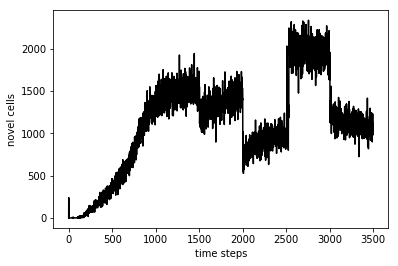

In [10]:
plt.plot(g.nnovelcells[:3500],'black')
plt.xlabel('time steps')
plt.ylabel('novel cells')

In [15]:
# 12 Test of critical edge of proliferation
#  selection=12 LUT with appropriate parameters for survival
#  this case uses the genes to encode the canonical rotation and s dept rule tables for birth and survival
#  a fixed positional encoding is used in the gene with 1-bit for each canonical rotation in the 32 bit survival and birth masks
#  there are 1,1,4,7,10,7,4,1,1 canonical rotation mask bits for s=0-8. Only 32 cases s=2-6 in LUT are allowed non-zero.
#  birth is determined by the and of the live neighbour genes (and 32 bits of overwritemask) ie genecode
#  survival is determined the and of the live neighbour genes (and 32 bits of survivalmask) ie genecode
#  ncoding not used : only space for 1 bit per lut entry
#  this example allows only one of the 4 canonical rotations for s=2 to be gene activated for birth, otherwise <=GoL
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=1;# simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 0x1             # 0,1 whether to allow GoL rule modifications
g.repscheme = g.runparams[1] = 0x150         
g.selection     = g.runparams[2] = 12        # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0xff      # mask of bits to overwrite if birth allowed and already occupied for bit position sum s
g.birthmask    = g.runparams[7] = 0x000007ff # for selection=12-13 this is the GoL birth mask
g.survivalmask = g.runparams[4] = 0x00000000 # for selection=12-13 this is the GoL survival mask
g.ancselectmask = g.runparams[8] = 0xff      # ancestor mask allowing selection for all s values
g.colorfunction = g.runparams[5] = 0         # color function can be cahnged with arrow keys
g.initfield = g.runparams[6] = 0             # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] = 8192    # initial 1 density in GOL state: 16384 = nearest to half of C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 16384   # initial density of random genes
g.ncoding = g.simparams[3] = 0               # for selection==12 no meaning
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
#g.step(True)
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

step 1503 birthmask changed to 7f7
step 2006 birthmask changed to 7ff
step 2014 birthmask changed to 7fb
step 2506 birthmask changed to 7ff
step 3002 birthmask changed to 7f7
step 3013 birthmask changed to 7f3
step 3512 birthmask changed to 7f7
step 3522 birthmask changed to 7ff
step 4004 birthmask changed to 7fd
step 4513 birthmask changed to 7f9
step 5132 collected trace of nnovelcells


Text(0, 0.5, 'novel cells')

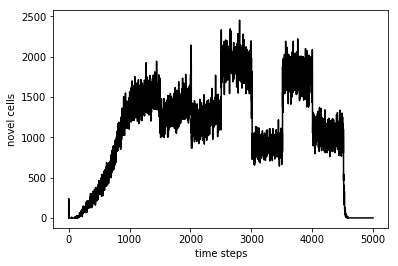

In [19]:
plt.plot(g.nnovelcells[:5000],'black')
plt.xlabel('time steps')
plt.ylabel('novel cells')

### 12.4 Example with selection==12

In [ ]:
# 12
#  selection=12 LUT with appropriate parameters for survival
#  this case uses the genes to encode the canonical rotation and s dept rule tables for birth and survival
#  a fixed positional encoding is used in the gene with 1-bit for each canonical rotation in the 32 bit survival and birth masks
#  there are 1,1,4,7,10,7,4,1,1 canonical rotation mask bits for s=0-8. Only 32 cases s=2-6 in LUT are allowed non-zero.
#  birth is determined by the and of the live neighbour genes (and 32 bits of overwritemask) ie genecode
#  survival is determined the and of the live neighbour genes (and 32 bits of survivalmask) ie genecode
#  ncoding not used : only space for 1 bit per lut entry
#  this example allows only one of the 4 canonical rotations for s=2 to be gene activated for birth, otherwise <=GoL
g.nrun=1; g.ndisp=100; g.nskip=0; g.niter=1;# simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                             # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
g.repscheme = g.runparams[1] = 0x641         # 
g.selection = g.runparams[2] = 12            # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3]= 0x0        # 
g.birthmask = g.runparams[7]= 0x000007f0     # for selection=8-13 this is the GoL birth mask
g.survivalmask = g.runparams[4] = 0x000007ff # for selection=8-13 this is the GoL survival mask
g.colorfunction = g.runparams[5] = 0         # color function 0(hash), ≥1(fnal), 2 nongulstate or color gol planes, 3 notgolrul yellow
                                             # 4 activities 5 genealogy steps 6 genealogy temporal 7 activity scaled colors
g.initfield = g.runparams[6] = 100           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  16384  # initial 1 density in GOL state
                                             # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 0       # initial density of random genes
g.ncoding = g.simparams[3] = 0               # for selection 10, non zero value means grow plane community from 0
                                             # otherwise (selection<10) no of bits used to encode valid connection functions 1-16
                                             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0(False)
# step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, True)

## 13 Selection: Canonical rotation LUT encoded by gene with variable length encoding

### 13.1 Game of Life with selection==13

In [7]:
# 13 GoL
#  selection=13 LUT with appropriate parameters for survival
#  this case uses the genes to encode the canonical rotation and s dept rule tables for birth and survival
#  a variable length encoding is used in the gene with 4+1+5 bits, 4-bits for the survival and birth s value as in 8,
#  and 5 bits for subset of canonical rotations (1/2) determined by 1 further bit.
#  there are 1,1,4,7,10,7,4,1,1 canonical rotation masks for s=0-8. Only 32 cases s=2-6 are lut allowed non-zero.
#  birth is determined by existence of an entry from any of the live neighbour genes (and 32 bits of overwritemask) ie genecode
#  survival determined by existence of an entry from any of the live neighbour genes (and 32 bits of survivalmask) ie genecode
#  ncoding not used : only space for 1 bit per lut entry
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=1;# simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                             # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
g.repscheme = g.runparams[1] = 0x0610        # 
g.selection     = g.runparams[2] = 13        # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0x00      # no overwrite allowed in this version, alternatively set to 0x04 for overwrite on s=3 birth
g.survivalmask = g.runparams[4] = 0x000007ff # for selection=12-13 this is the GoL survival mask
g.birthmask    = g.runparams[7] = 0x000007f0 # for selection=12-13 this is the GoL birth mask
g.ancselectmask = g.runparams[8] = 0xff      # ancestor mask allowing selection for all s values
g.colorfunction = g.runparams[5] = 0         # color function 0(hash), ≥1(fnal), 2 nongulstate or color gol planes, 3 notgolrul yellow
                                             # 4 activities 5 genealogy steps 6 genealogy temporal 7 activity scaled colors
g.initfield = g.runparams[6] = 100           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  16384  # initial 1 density in GOL state
                                             # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 0       # initial density of random genes
g.ncoding = g.simparams[3] = 0               # for selection 10, non zero value means grow plane community from 0
                                             # otherwise (selection<10) no of bits used to encode valid connection functions 1-16
                                             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
# step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

### 13.2 Scissors-paper-stone-well selection with selection==13

In [16]:
# 13 Scissor-paper-stone-well selection 
#  selection=13 LUT with appropriate parameters for survival
#  this case uses the genes to encode the canonical rotation and s dept rule tables for birth and survival
#  a variable length encoding is used in the gene with 4+1+5 bits, 4-bits for the survival and birth s value as in 8,
#  and 5 bits for subset of canonical rotations (1/2) determined by 1 further bit.
#  there are 1,1,4,7,10,7,4,1,1 canonical rotation masks for s=0-8. Only 32 cases s=2-6 are lut allowed non-zero.
#  birth is determined by existence of an entry from any of the live neighbour genes (and 32 bits of overwritemask) ie genecode
#  survival determined by existence of an entry from any of the live neighbour genes (and 32 bits of survivalmask) ie genecode
#  ncoding not used : only space for 1 bit per lut entry
g.nrun=4; g.ndisp=1000; g.nskip=0; g.niter=1;# simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 0x1             # 0,1 whether to allow GoL rule modifications
g.repscheme = g.runparams[1] = 0x170         
g.selection     = g.runparams[2] = 13        # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0x06      # mask of bits to overwrite if birth allowed and already occupied for bit position sum s
g.birthmask    = g.runparams[7] = 0x07ff     # for selection=12-13 this is the GoL birth mask with birth for s=2 added
g.survivalmask = g.runparams[4] = 0x0        # this is the no survival mask
g.ancestormask = g.runparams[8] = 0xff       # ancestor mask allowing selection for all cases
g.colorfunction = g.runparams[5] = 0         # color function can be cahnged with arrow keys
g.initfield = g.runparams[6] = 150           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] = 8192    # initial 1 density in GOL state: 16384 = nearest to half of C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 0       # initial density of random genes
g.ncoding = g.simparams[3] = 0               # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
#g.step(True)
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

### 13.3 Golr based selection

In [4]:
# 13 Scissor-paper-stone-well selection 
#  selection=13 LUT with appropriate parameters for survival
#  this case uses the genes to encode the canonical rotation and s dept rule tables for birth and survival
#  a variable length encoding is used in the gene with 4+1+5 bits, 4-bits for the survival and birth s value as in 8,
#  and 5 bits for subset of canonical rotations (1/2) determined by 1 further bit.
#  there are 1,1,4,7,10,7,4,1,1 canonical rotation masks for s=0-8. Only 32 cases s=2-6 are lut allowed non-zero.
#  birth is determined by existence of an entry from any of the live neighbour genes (and 32 bits of overwritemask) ie genecode
#  survival determined by existence of an entry from any of the live neighbour genes (and 32 bits of survivalmask) ie genecode
#  ncoding not used : only space for 1 bit per lut entry
g.nrun=4; g.ndisp=1000; g.nskip=0; g.niter=1;# simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step

g.rulemod = g.runparams[0] = 0x1             
g.repscheme = g.runparams[1] = 0x6b2         
g.selection     = g.runparams[2] = 13        
g.overwritemask = g.runparams[3] = 0xff      
g.birthmask    = g.runparams[7] = 0x07ff     
g.survivalmask = g.runparams[4] = 0x0        
g.ancestormask = g.runparams[8] = 0xff       
g.colorfunction = g.runparams[5] = 0         
g.initfield = g.runparams[6] = 0             
g.nlog2pmut = g.simparams[0] = 8             
g.initial1density = g.simparams[1] = 8192    
g.initialrdensity = g.simparams[2] = 16384   
g.ncoding = g.simparams[3] = 0              
g.startgenechoice = g.simparams[4] = 8      

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
#g.step(True)
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

step 80 birthmask changed to 7fe
step 352 birthmask changed to 7be
step 384 birthmask changed to 79e
step 452 birthmask changed to 7be
step 624 birthmask changed to 3be
step 672 birthmask changed to 1be
step 740 birthmask changed to be
step 816 birthmask changed to 3e
step 884 birthmask changed to be
step 1544 birthmask changed to b6
step 1616 birthmask changed to be
step 1708 birthmask changed to fe
step 1916 birthmask changed to f6
step 2008 birthmask changed to 1f6
step 2024 birthmask changed to 3f6
step 2040 birthmask changed to 7f6
step 2072 birthmask changed to 7f2
step 2108 birthmask changed to 7f6
step 2148 birthmask changed to 7f4
step 2172 birthmask changed to 7f6
step 2360 birthmask changed to 7fe
step 2440 birthmask changed to 7fc
step 2472 birthmask changed to 7fe
step 2524 birthmask changed to 7fa
step 2696 birthmask changed to 7ba
step 2732 birthmask changed to 7fa
step 2904 birthmask changed to 7fb
step 2980 birthmask changed to 7ff
step 3048 birthmask changed to 5ff
st

step 15328 repscheme changed to 192
step 15352 repscheme changed to 1b2
step 15368 repscheme changed to 1f2


### 13.4 Example with selection==13

In [ ]:
# 13
#  selection=13 LUT with appropriate parameters for survival
#  this case uses the genes to encode the canonical rotation and s dept rule tables for birth and survival
#  a variable length encoding is used in the gene with 4+1+5 bits, 4-bits for the survival and birth s value as in 8,
#  and 5 bits for subset of canonical rotations (1/2) determined by 1 further bit.
#  there are 1,1,4,7,10,7,4,1,1 canonical rotation masks for s=0-8. Only 32 cases s=2-6 are lut allowed non-zero.
#  birth is determined by existence of an entry from any of the live neighbour genes (and 32 bits of overwritemask) ie genecode
#  survival determined by existence of an entry from any of the live neighbour genes (and 32 bits of survivalmask) ie genecode
#  ncoding not used : only space for 1 bit per lut entry
g.nrun=1; g.ndisp=100; g.nskip=0; g.niter=1; # simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                             # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
g.repscheme = g.runparams[1] = 0x80          # repscheme bit 3 (val 0x8) determines whether random choice of ancestor amongst live neighbours
                                             # repscheme mod 8 i.e. 0-7 determines selection scheme based on gene
                                             # 0 minimum gene as value  # 1 maximum gene as value
                                             # 2 minimum number of ones # 3 maximum number of ones
                                             # 4 neutral selection # 5 neutral but different selection
                                             # 6 penalty function -1 for a survival rule -2 for a birth rule  # 7 not allowed
g.selection = g.runparams[2] = 13            # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3]= 0x0        #
g.birthmask = g.runparams[7]= 0x000007f0     # for selection=12-13 this is the GoL birth mask
g.survivalmask = g.runparams[4] = 0x000007ff # for selection=12-13 this is the GoL survival mask
g.colorfunction = g.runparams[5] = 0         # color function 0(hash), ≥1(fnal), 2 nongulstate or color gol planes, 3 notgolrul yellow
                                             # 4 activities 5 genealogy steps 6 genealogy temporal 7 activity scaled colors
g.initfield = g.runparams[6] = 150           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 7             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  16384  # initial 1 density in GOL state
                                             # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 16384       # initial density of random genes
g.ncoding = g.simparams[3] = 0               # for selection 10, non zero value means grow plane community from 0
                                             # otherwise (selection<10) no of bits used to encode valid connection functions 1-16
                                             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
# g.step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

In [ ]:
g.set_params()
g.genelife.initialize(g.runparams,g.simparams)
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

## 14 Selection: Symmetric 2D LUT encoded by gene with fixed length positional encoding

### 14.1 Game of Life with selection==14

In [8]:
# 14 GoL
#  selection=14 LUT with appropriate parameters for survival
#  this case uses the genes to encode all possible configuration rule tables (up to spatial symmetry (4-rotations, 4-reflections)) for birth and survival
#  a fixed length encoding is used in the gene with 1-bit for each of 64 configurations in the 32 bit survival and 32 bit birth masks
#  there are 1,2,6,10,13,10,6,2,1 configuration mask bits for s=0-8. Only 32 cases s=0-4 in LUT are allowed non-zero in this implementation.
#  birth and survival are determined by the presence of a bit in the gene at the position of the symmetric live-nb pattern LUT 
#  ncoding not used : only space for 1 bit per lut entry
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=1;# simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 0x1             # 0,1 whether to allow GoL rule modifications
g.repscheme = g.runparams[1] = 0x610         
g.selection     = g.runparams[2] = 14        # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0x00      # mask of bits to overwrite if birth allowed and already occupied for bit position sum s
g.birthmask    = g.runparams[7] = 0x0007fe00 # for selection=14-15 this is the GoL birth mask
g.survivalmask = g.runparams[4] = 0x0007fff8 # for selection=14-15 this is the GoL survival mask
g.ancselectmask = g.runparams[8] = 0xff      # ancestor mask allowing selection for all s values
g.colorfunction = g.runparams[5] = 0         # color function can be cahnged with arrow keys
g.initfield = g.runparams[6] = 150           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] = 8192    # initial 1 density in GOL state: 16384 = nearest to half of C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 0       # initial density of random genes
g.ncoding = g.simparams[3] = 0               # for selection==14 no meaning
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
#g.step(True)
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

### 14.2 Scissors-paper-stone-well selection with selection==14

In [17]:
# 14 GoL
#  selection=14 LUT with appropriate parameters for survival
#  this case uses the genes to encode all possible configuration rule tables (up to spatial symmetry (4-rotations, 4-reflections)) for birth and survival
#  a fixed length encoding is used in the gene with 1-bit for each of 64 configurations in the 32 bit survival and 32 bit birth masks
#  there are 1,2,6,10,13,10,6,2,1 configuration mask bits for s=0-8. Only 32 cases s=0-4 in LUT are allowed non-zero in this implementation.
#  birth and survival are determined by the presence of a bit in the gene at the position of the symmetric live-nb pattern LUT 
#  ncoding not used : only space for 1 bit per lut entry
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=1;# simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 0x1             # 0,1 whether to allow GoL rule modifications
g.repscheme = g.runparams[1] = 0x170         
g.selection     = g.runparams[2] = 14        # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0x06      # mask of bits to overwrite if birth allowed and already occupied for bit position sum s
g.birthmask    = g.runparams[7] = 0x0007fff8 # for selection=14-15 this is the GoL birth mask
g.survivalmask = g.runparams[4] = 0x0        # for selection=14-15 this is no survival
g.ancselectmask = g.runparams[8] = 0xff      # ancestor mask allowing selection for all s values
g.colorfunction = g.runparams[5] = 0         # color function can be cahnged with arrow keys
g.initfield = g.runparams[6] = 150           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] = 8192    # initial 1 density in GOL state: 16384 = nearest to half of C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 0       # initial density of random genes
g.ncoding = g.simparams[3] = 0               # for selection==14 no meaning
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
#g.step(True)
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

### 14.3 Test of symmetry breaking expansion of rules

In [20]:
# 14 Near proliferation threshold
#  selection=14 LUT with appropriate parameters for survival
#  this case uses the genes to encode all possible configuration rule tables (up to spatial symmetry (4-rotations, 4-reflections)) for birth and survival
#  a fixed length encoding is used in the gene with 1-bit for each of 64 configurations in the 32 bit survival and 32 bit birth masks
#  there are 1,2,6,10,13,10,6,2,1 configuration mask bits for s=0-8. Only 32 cases s=0-4 in LUT are allowed non-zero in this implementation.
#  birth and survival are determined by the presence of a bit in the gene at the position of the symmetric live-nb pattern LUT 
#  ncoding not used : only space for 1 bit per lut entry
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=1;# simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 0x1             # 0,1 whether to allow GoL rule modifications
g.repscheme = g.runparams[1] = 0x150         
g.selection     = g.runparams[2] = 14        # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0xff      # mask of bits to overwrite if birth allowed and already occupied for bit position sum s
g.birthmask    = g.runparams[7] = 0x0007fff8 # for selection=14-15 this is the GoL birth mask
g.survivalmask = g.runparams[4] = 0x0007fff8 # for selection=14-15 this is the GoL survival mask
g.ancselectmask = g.runparams[8] = 0xff      # ancestor mask allowing selection for all s values
g.colorfunction = g.runparams[5] = 0         # color function can be cahnged with arrow keys
g.initfield = g.runparams[6] = 0             # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] = 8192    # initial 1 density in GOL state: 16384 = nearest to half of C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 16384   # initial density of random genes
g.ncoding = g.simparams[3] = 0               # for selection==14 no meaning
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
#g.step(True)
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

step 0 pixel data (236,287) gol 0 gene 0000000000000000 status 0000000000000000
step 1009 birthmask changed to 7fef8
step 1506 birthmask changed to 7fe78
step 2004 birthmask changed to 7fe38
step 2547 birthmask changed to 7fe78
step 2553 birthmask changed to 7fef8
step 2560 birthmask changed to 7fff8
step 3003 birthmask changed to 7fff0
step 3506 birthmask changed to 7ffe0
step 3893 birthmask changed to 7fff0
step 4080 birthmask changed to 7fff8
step 4510 birthmask changed to 7ffd8
step 5005 birthmask changed to 7ff98
step 5505 birthmask changed to 7ff18
step 5976 birthmask changed to 7fe18
step 6527 birthmask changed to 7fe10
step 6571 birthmask changed to 7fe18
step 6957 birthmask changed to 7fe08
step 7671 birthmask changed to 7fe00
step 7685 birthmask changed to 7fe08
step 8000 birthmask changed to 7fe18
step 8506 birthmask changed to 7fe10
step 8524 birthmask changed to 7fe18
step 8535 birthmask changed to 7fe10
step 8547 birthmask changed to 7fe18
step 8555 birthmask changed to 7

Text(0, 0.5, 'novel cells')

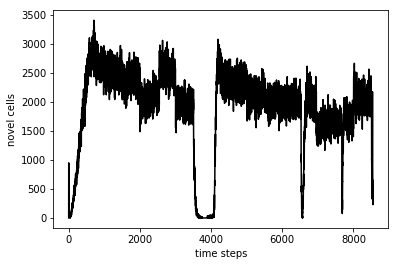

In [25]:
plt.plot(g.nnovelcells[:8550],'black')
plt.xlabel('time steps')
plt.ylabel('novel cells')

### 14.4 Example with selection==14

In [ ]:
# 14
#  selection=14 LUT with appropriate parameters for survival
#  this case uses the genes to encode all possible configuration rule tables (up to spatial symmetry (4-rotations, 4-reflections)) for birth and survival
#  a fixed length encoding is used in the gene with 1-bit for each of 64 configurations in the 32 bit survival and 32 bit birth masks
#  there are 1,2,6,10,13,10,6,2,1 configuration mask bits for s=0-8. Only 32 cases s=0-4 in LUT are allowed non-zero in this implementation.
#  birth and survival are determined by the presence of a bit in the gene at the position of the symmetric live-nb pattern LUT 
#  ncoding not used : only space for 1 bit per lut entry
g.nrun=1; g.ndisp=100; g.nskip=0; g.niter=1;# simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                             # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
g.repscheme = g.runparams[1] = 0x660         # repscheme bit 3 (val 0x8) determines whether random choice of ancestor amongst live neighbours
                                             # repscheme mod 8 i.e. 0-7 determines selection scheme based on gene
                                             # 0 minimum gene as value  # 1 maximum gene as value
                                             # 2 minimum number of ones # 3 maximum number of ones
                                             # 4 neutral selection # 5 neutral but different selection
                                             # 6 penalty function -1 for a survival rule -2 for a birth rule  # 7 not allowed 
g.selection = g.runparams[2] = 14            # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3]= 0x0        # 
g.birthmask = g.runparams[7]    = 0x7fe00    # for selection=14-15 this is the GoL birth mask
g.survivalmask = g.runparams[4] = 0x7fff8    # for selection=14-15 this is the GoL survival mask
g.colorfunction = g.runparams[5] = 0         # color function 0(hash), ≥1(fnal), 2 nongulstate or color gol planes, 3 notgolrul yellow
                                             # 4 activities 5 genealogy steps 6 genealogy temporal 7 activity scaled colors
g.initfield = g.runparams[6] = 100           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  16384  # initial 1 density in GOL state
                                             # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 16384   # initial density of random genes
g.ncoding = g.simparams[3] = 0               # for selection 10, non zero value means grow plane community from 0
                                             # otherwise (selection<10) no of bits used to encode valid connection functions 1-16
                                             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0(False)
# step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, True)

## 15 Selection: Symmetric 2D LUT encoded by gene with fixed length positional encoding

### 15.1 Game of Life with selection==15

In [10]:
# 15 GoL
#  selection=15 LUT with appropriate parameters for survival
#  this case uses the genes to encode all possible configuration rule tables (up to spatial symmetry (4-rotations, 4-reflections)) for birth and survival
#  a modular encoding is used in the gene with 12-bit modules for subsets of up to 6 configurations in the 32 bit survival and 32 bit birth masks
#  there are 1,2,6,10,13,10,6,2,1 configuration mask bits for s=0-8. Only 32 cases s=0-4 in LUT are allowed non-zero in this implementation.
#  birth and survival are determined by the presence of a module with the correct pattern in the gene
#  ncoding not used : only space for 1 bit per lut entry
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=1;# simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                             # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
g.repscheme = g.runparams[1] = 0x0610        # 
g.selection     = g.runparams[2] = 15        # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0x00      # no overwrite allowed in this version, alternatively set to 0x04 for overwrite on s=3 birth
g.birthmask    = g.runparams[7] = 0x0007fe00 # for selection=14-15 this is the GoL birth mask
g.survivalmask = g.runparams[4] = 0x0007fff8 # for selection=14-15 this is the GoL survival mask
g.ancselectmask = g.runparams[8] = 0xff      # ancestor mask allowing selection for all s values
g.colorfunction = g.runparams[5] = 0         # color function 0(hash), ≥1(fnal), 2 nongulstate or color gol planes, 3 notgolrul yellow
                                             # 4 activities 5 genealogy steps 6 genealogy temporal 7 activity scaled colors
g.initfield = g.runparams[6] = 100           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  16384  # initial 1 density in GOL state
                                             # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 0       # initial density of random genes
g.ncoding = g.simparams[3] = 0               # for selection 10, non zero value means grow plane community from 0
                                             # otherwise (selection<10) no of bits used to encode valid connection functions 1-16
                                             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
# step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

step 995 pixel data (131,422) gol 0 gene 0000000000000000 status 0000000000000000
step 1654 pixel data (202,260) gol 0 gene 0000000000000000 status 0000000000000000


### 15.2 Scissors-paper-stone-well selection with selection==15

In [18]:
# 15 Scissors-paper-stone-well selection
#  selection=15 LUT with appropriate parameters for survival
#  this case uses the genes to encode all possible configuration rule tables (up to spatial symmetry (4-rotations, 4-reflections)) for birth and survival
#  a modular encoding is used in the gene with 12-bit modules for subsets of up to 6 configurations in the 32 bit survival and 32 bit birth masks
#  there are 1,2,6,10,13,10,6,2,1 configuration mask bits for s=0-8. Only 32 cases s=0-4 in LUT are allowed non-zero in this implementation.
#  birth and survival are determined by the presence of a module with the correct pattern in the gene
#  ncoding not used : only space for 1 bit per lut entry
g.nrun=4; g.ndisp=1000; g.nskip=0; g.niter=1;# simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 0x1             # 0,1 whether to allow GoL rule modifications
g.repscheme = g.runparams[1] = 0x170         
g.selection     = g.runparams[2] = 15        # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0x06      # mask of bits to overwrite if birth allowed and already occupied for bit position sum s
g.birthmask    = g.runparams[7] = 0x0007fff8 # for selection=14-15 this is the GoL birth mask with s=2 birth added
g.survivalmask = g.runparams[4] = 0x0        # this is the no survival mask
g.ancestormask = g.runparams[8] = 0xff       # ancestor mask allowing selection for all cases
g.colorfunction = g.runparams[5] = 0         # color function can be cahnged with arrow keys
g.initfield = g.runparams[6] = 150           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] = 8192    # initial 1 density in GOL state: 16384 = nearest to half of C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 0       # initial density of random genes
g.ncoding = g.simparams[3] = 0               # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
#g.step(True)
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

### 15.3 Example with selection==15

In [ ]:
# 15
#  selection=15 LUT with appropriate parameters for survival
#  this case uses the genes to encode all possible configuration rule tables (up to spatial symmetry (4-rotations, 4-reflections)) for birth and survival
#  a modular encoding is used in the gene with 12-bit modules for subsets of up to 6 configurations in the 32 bit survival and 32 bit birth masks
#  there are 1,2,6,10,13,10,6,2,1 configuration mask bits for s=0-8. Only 32 cases s=0-4 in LUT are allowed non-zero in this implementation.
#  birth and survival are determined by the presence of a module with the correct pattern in the gene
#  ncoding not used : only space for 1 bit per lut entry
g.nrun=1; g.ndisp=100; g.nskip=0; g.niter=1;# simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                             # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
g.repscheme = g.runparams[1] = 0x610         # repscheme bit 3 (val 0x8) determines whether random choice of ancestor amongst live neighbours
                                             # repscheme mod 8 i.e. 0-7 determines selection scheme based on gene
                                             # 0 minimum gene as value  # 1 maximum gene as value
                                             # 2 minimum number of ones # 3 maximum number of ones
                                             # 4 neutral selection # 5 neutral but different selection
                                             # 6 penalty function -1 for a survival rule -2 for a birth rule  # 7 not allowed 
g.selection = g.runparams[2] = 15            # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3]= 0x0        # 
g.birthmask = g.runparams[7]    = 0x7fe00    # for selection=14-15 this is the GoL birth mask
g.survivalmask = g.runparams[4] = 0x7fff8    # for selection=14-15 this is the GoL survival mask
g.colorfunction = g.runparams[5] = 0         # color function 0(hash), ≥1(fnal), 2 nongulstate or color gol planes, 3 notgolrul yellow
                                             # 4 activities 5 genealogy steps 6 genealogy temporal 7 activity scaled colors
g.initfield = g.runparams[6] = 100           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  16384  # initial 1 density in GOL state
                                             # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 0       # initial density of random genes
g.ncoding = g.simparams[3] = 0               # for selection 10, non zero value means grow plane community from 0
                                             # otherwise (selection<10) no of bits used to encode valid connection functions 1-16
                                             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0(False)
#g.step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, True)

In [ ]:
g.set_params()
g.genelife.initialize(g.runparams,g.simparams)
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)